In [1]:
import awkward as ak
#import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
import hist
import os
from pprint import pprint 
from glob import glob
hep.style.use(hep.style.ROOT)

from coffea import processor
from coffea.util import load
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.processor import column_accumulator

import vector
vector.register_awkward()


In [3]:
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/RecoPlots/DataPlots/Zee_Run2018D/"
input_folder_must = "/eos/user/r/rdfexp/ecal/cluster/raw_files/EGamma/Dumper_Mustache_bugFix/220919_211119"
input_folder_deep = "/eos/user/r/rdfexp/ecal/cluster/raw_files/EGamma/Dumper_DeepSC_algoA_bugFix/220919_211359"

fileset = {
    "DeepSC": glob(input_folder_deep+"/*/*.root", recursive=True)[0:20],
    "Mustache": glob(input_folder_must+"/*/*.root", recursive=True)[0:20]
}

In [16]:
patEle_fields = list(map( lambda k: k.strip().replace("patElectron_",""),
                         open("patElectron_fields.txt").readlines()))

In [15]:
patEle_fields

NameError: name 'patEle_fields' is not defined

# Coffea processor

In [ ]:

class ZeeProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        vector.register_awkward()
        electrons = ak.zip({k:events["patElectron_" + k] for k in patEle_fields},
                           with_name="Momentum4D")
        
        nele_init = ak.num(electrons, axis=1)
        
        id_mask = (electrons.egmCutBasedElectronIDloose==1)
        # Trying to replicate the skim selection
        #https://cmssdt.cern.ch/lxr/source/DPGAnalysis/Skims/python/ZElectronSkim_cff.py
#         mask_skim = (electrons.pt >= 10) &\
#                     ( ((abs(electrons.eta)<=1.4442) &(\
#                         (electrons.full5x5_refinedSCSigmaIEtaIEta < 0.0128)&\
#                         (electrons.deltaEtaIn < 0.00523)&\
#                         (electrons.deltaPhiIn < 0.159)&\
#                         (electrons.HoE < 0.247)&\
#                         (electrons.misHits<2)\
#                         ))|
#                         ((abs(electrons.eta)>=1.4442)&(abs(electrons.eta)<=2.5)&\
#                          (electrons.full5x5_refinedSCSigmaIEtaIEta < 0.0445)&\
#                          (electrons.deltaEtaIn < 0.00984)&\
#                          (electrons.deltaPhiIn < 0.157)&\
#                          (electrons.HoE < 0.0982)&\
#                          (electrons.misHits<3)
#                         )
#                     )
        
        # The only missing cuts
        #relCombIsolationWithEACut      = cms.vdouble(0.168  ,0.185  )  , # relCombIsolationWithEALowPtCut
        #EInverseMinusPInverseCut       = cms.vdouble(0.193  ,0.0962   )  ,                
        
        electrons = electrons[id_mask]
        nele_clean = ak.num(electrons, axis=1)
        # Ask for at least two remaining electrons
        electrons = electrons[ak.num(electrons, axis=1)>=2]
        lead_ele = electrons[:, 0]
        sublead_ele = electrons[:,1]
        Z =  lead_ele + sublead_ele
        # Cleaning the event asking for at lead Z.mass 40, leading 20 and sublead 10
        event_mask = (Z.mass>40.)&(lead_ele.pt >= 20.)&(sublead_ele.pt >= 10.)
        
        electrons = electrons[event_mask]
        Z = Z[event_mask]
        lead_ele = lead_ele[event_mask]
        sublead_ele = sublead_ele[event_mask]
        events = events[event_mask]
        
          
        efficiency_hist = hist.new.Integer(start=0, stop=10, name="nele_initial",label="N. ele initial")\
                                  .Integer(start=0, stop=10, name="nele_clean", label="N. ele cleaned")\
                                  .Double().fill(nele_init, nele_clean)
        
        
        hist_leading_ele = hist.new.Reg(name="et", label="Leading electron $E_T$",
                                       bins=50, start=0, stop=200,)\
                            .Var([0, 0.5, 1, 1.4442, 1.566, 2., 2.5],name="eta", 
                                 label="Leading electron $\eta$")\
                            .Integer(start=1, stop=15, name="ncls", label="Number of PF Clusters")\
                            .IntCategory([0,1,2,3,4], name="class",label="electron class")\
                            .Double()\
                            .fill(lead_ele.et, 
                                  abs(lead_ele.eta),
                                  lead_ele.nPFClusters,
                                  lead_ele.classification)
        
        hist_subleading_ele = hist.new.Reg(name="et", label="Subleading electron $E_T$",
                                       bins=50, start=0, stop=200)\
                            .Var([0, 0.5, 1, 1.4442, 1.566, 2., 2.5],name="eta", 
                                 label="Subleading electron $\eta$")\
                            .Integer(start=1, stop=15, name="ncls", label="Number of PF Clusters")\
                            .IntCategory([0,1,2,3,4], name="class",label="electron class")\
                            .Double()\
                            .fill(sublead_ele.et, 
                                  abs(sublead_ele.eta),
                                  sublead_ele.nPFClusters,
                                  sublead_ele.classification)
   

        hist_Z = hist.new.Reg(name="zmass", bins=120, start=60, stop=120, label="Zmass")\
                             .Reg(name="et", label="Leading electron $E_T$",
                                       bins=30, start=0, stop=200)\
                            .Var([0, 0.5, 1, 1.4442, 1.566, 2., 2.5],name="eta", 
                                 label="Leading electron $\eta$")\
                            .Integer(start=1, stop=15, name="ncls", label="Number of PF Clusters")\
                            .Reg(name="rho", start=0, stop=70, bins=30, label="$\rho$")\
                            .IntCategory([0,1,2,3,4], name="class",label="electron class")\
                            .Double()\
                            .fill(Z.mass,
                                  lead_ele.et,
                                  abs(lead_ele.eta),
                                  lead_ele.nPFClusters,
                                  events.rho,
                                  lead_ele.classification)
        
        return {
            dataset: {
                "entries": len(events),
                "histos": {
                    "Z": hist_Z,
                    "nele_eff": efficiency_hist,
                    "ele_lead": hist_leading_ele,
                    "ele_sublead": hist_subleading_ele
                },
                "Z": {
                    "mass": column_accumulator(ak.to_numpy(Z.mass)),
                    "ele_et": column_accumulator(ak.to_numpy(lead_ele.et)),
                    "ele_eta": column_accumulator(ak.to_numpy(lead_ele.eta)),
                    "ele_class": column_accumulator(ak.to_numpy(lead_ele.classification)),
                    "rho":column_accumulator(ak.to_numpy(events.rho)),
                    "nvtx":column_accumulator(ak.to_numpy(events.nVtx)),
                    "r9": column_accumulator(ak.to_numpy(lead_ele.full5x5_refinedSCR9))
                }       
            }
        }

    def postprocess(self, accumulator):
        pass


In [17]:
iterative_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=4),
    schema=BaseSchema,
    maxchunks=10,
    
)

out = iterative_run(
    fileset,
    treename="recosimdumper/caloTree",
    processor_instance=ZeeProcessor(),
)
out

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

{'Mustache': {'Z': {'ele_class': column_accumulator(array([0, 1, 3, ..., 0, 3, 0], dtype=int32)),
   'ele_et': column_accumulator(array([50.829174, 43.697914, 31.751547, ..., 52.408344, 35.444435,
          46.58514 ], dtype=float32)),
   'ele_eta': column_accumulator(array([-2.029461  , -1.791851  ,  0.13757126, ..., -0.49773943,
           1.0391172 , -0.39091   ], dtype=float32)),
   'mass': column_accumulator(array([232.99066 , 303.52634 ,  49.526943, ...,  89.138916,  85.46639 ,
           90.830605], dtype=float32))},
  'entries': 4605,
  'histos': {'Z': Hist(
     Regular(120, 60, 120, name='zmass', label='Zmass'),
     Regular(30, 0, 200, name='et', label='Leading electron $E_T$'),
     Variable([0, 0.5, 1, 1.4442, 1.566, 2, 2.5], name='eta', label='Leading electron $\\eta$'),
     Integer(1, 15, name='ncls', label='Number of PF Clusters'),
     IntCategory([0, 1, 2, 3, 4], name='class', label='electron class'),
     storage=Double()) # Sum: 2169.0 (2986.0 with flow),
   'ele_s

# Output analysis

In [224]:
def plot_comparison(dfB, dfA, var, label, bins, xrange, output_folder, 
                    ylog=False, wA=None, wB=None, flatten=False,density=False,
                    legendB="Mustache", legendA="DeepSC", text=None, ratio_lim=(0.8,1.2) ):
    
    fig = plt.figure(figsize=(10,11), dpi=72)
    gs = fig.add_gridspec(2,1, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)
    
    ax =  axs[0]
    axr =  axs[1]
    
    if flatten:
        dfA = ak.flatten(dfA)
        dfB = ak.flatten(dfB)
    
    B, binX, _ = ax.hist(dfB, bins=bins, range=xrange,  weights=wB,
                         label=legendB, histtype="step", linewidth=2, density=density)
    A, binX, _ = ax.hist(dfA, bins=bins, range=xrange, weights=wA,
                         label=legendA, histtype="step", linewidth=2, density=density)
    
    if density:
        errA,_ = np.histogram(dfA, bins=bins, range=xrange, weights=wA)
        errB,_ = np.histogram(dfB, bins=bins, range=xrange, weights=wB)
    else:
        errA = np.sqrt(A)
        errB = np.sqrt(B)

    ax.legend()
    axr.set_xlabel(label)
    
    if text!=None:
        ax.text(0.07, 0.87, text, transform=ax.transAxes)
        
    hep.cms.label(llabel="Data", rlabel="Run2018C Zee skim", loc=0, ax=ax)
    
   
    mmax = max([max(A), max(B)])
    if ylog:
        ax.set_ylim(max([min(A), min(B),1e-3]), mmax*500)
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, mmax*1.4)
         

    errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)

    ratio= np.where( (A>0)&(B>0),
                     A/B,
                     1.) 
    
    centers = (np.roll(binX, -1) + binX)/2
 
    axr.errorbar(centers[:-1], ratio, xerr=0, yerr=errR,
                                fmt=".", linestyle='none', elinewidth=1, c="black")
    
    if ratio_lim =="auto":
        deltaMax = max([np.max(ratio), 1.1])
        deltaMin = min([np.min(ratio), 0.9])

        #print(deltaM)
        axr.set_ylim(max(0, deltaMin*0.9), deltaMax*1.1)
    else:
        axr.set_ylim(*ratio_lim)
    axr.set_ylabel("ratio")
    axr.grid(which="both",axis="y")
    axr.plot([binX[0], binX[-1]], [1.,1.], linewidth=2, c="black")

    if output_folder!=None:
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + f"/{var}_comparison.png")
        fig.savefig(output_folder + f"/{var}_comparison.pdf")
        fig.savefig(output_folder + f"/{var}_comparison.svg")
        
        
def plot_comparison_H(Hb, Ha, var, output_folder, legendB="Mustache", legendA="DeepSC", 
                    ylog=False, density=False):
    
    fig = plt.figure(figsize=(10,11), dpi=72)
    gs = fig.add_gridspec(2,1, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)
    
    ax =  axs[0]
    axr =  axs[1]
    
    hep.histplot(Hb, label=legendB, density=density, ax=ax, linewidth=2)
    hep.histplot(Ha, label=legendA, density=density, ax=ax, linewidth=2)
        
    A = Ha.values()
    B = Hb.values()
    errA = np.sqrt(A)
    errB = np.sqrt(B)

    ax.legend()
    axr.set_xlabel(Ha.axes[0].label)
    hep.cms.label(llabel="Data", rlabel="Run2018C Zee skim", loc=0, ax=ax)
    mmax = max([max(A), max(B)])
    if ylog:
        ax.set_ylim(max([min(A), min(B),1e-3]), mmax*500)
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, mmax*1.4)


    errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)

    ratio= np.where( (A>0)&(B>0),
                     A/B,
                     1.) 
    
    if isinstance(Ha.axes[0], hist.axis.Integer):
        centers = Ha.axes[0].centers -1 
        edges = Ha.axes[0].edges -1
    else:
        centers = Ha.axes[0].centers
        edges = Ha.axes[0].edges
    
 
    axr.errorbar(centers, ratio, xerr=0, yerr=errR,
                fmt=".", linestyle='none', elinewidth=1, c="black")

    deltaMax = max([np.max(ratio), 1.1])
    deltaMin = min([np.min(ratio), 0.9])

    #print(deltaM)
    axr.set_ylim(max(0, deltaMin*0.9), deltaMax*1.1)
    axr.set_ylabel("ratio")
    axr.grid(which="both",axis="y")
    axr.plot([edges[0], edges[-1]], [1.,1.], linewidth=2, c="black")

    if output_folder!=None:
        os.makedirs(output_folder, exist_ok=True)
        fig.savefig(output_folder + f"/{var}_comparison.png")
        fig.savefig(output_folder + f"/{var}_comparison.pdf")
        fig.savefig(output_folder + f"/{var}_comparison.svg")
    


In [5]:
out = load("output.coffea")

In [6]:
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/RecoPlots/DataPlots/Zee_Run2018D/"

In [7]:
Zd = pd.DataFrame({k:v.value for k,v in out["DeepSC"]["Z"].items()})
Zm = pd.DataFrame({k:v.value for k,v in out["Mustache"]["Z"].items()})

In [93]:
Zd

,mass,ele_et,ele_eta,ele_class,rho,nvtx,r9
0,118.824913,102.984940,0.608241,0,13.371253,20,0.972687
1,91.625328,47.248871,0.531169,0,21.244678,33,0.994823
2,97.944847,52.334866,-0.878557,0,33.025944,40,0.990007
3,119.143181,44.154648,0.749653,2,23.682571,34,0.693759
4,91.600349,45.370144,-0.084108,0,32.417774,48,0.969589
...,...,...,...,...,...,...,...
2259413,95.013916,63.117134,0.109753,0,25.350348,38,0.969674
2259414,314.547668,46.111347,-2.414677,0,28.256405,45,1.016361
2259415,82.483780,35.381027,-2.469308,0,15.305987,24,1.023605
2259416,130.979584,44.585289,-0.468125,3,15.940783,27,0.957182


# Efficiency study

In [9]:
H = out["DeepSC"]["histos"]["nele_eff"]

In [10]:
H

Hist(
  Integer(0, 10, name='nele_initial', label='N. ele initial'),
  Integer(0, 10, name='nele_clean', label='N. ele cleaned'),
  storage=Double()) # Sum: 3425733.0 (3425740.0 with flow)

### Scaling

In [11]:
D_ov_M = out["Mustache"]["entries"]/out["DeepSC"]["entries"]
D_ov_M

1.2205780426640842

### Efficiency plots

/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:98: RuntimeWarning: invalid value encountered in true_divide
  A/B,


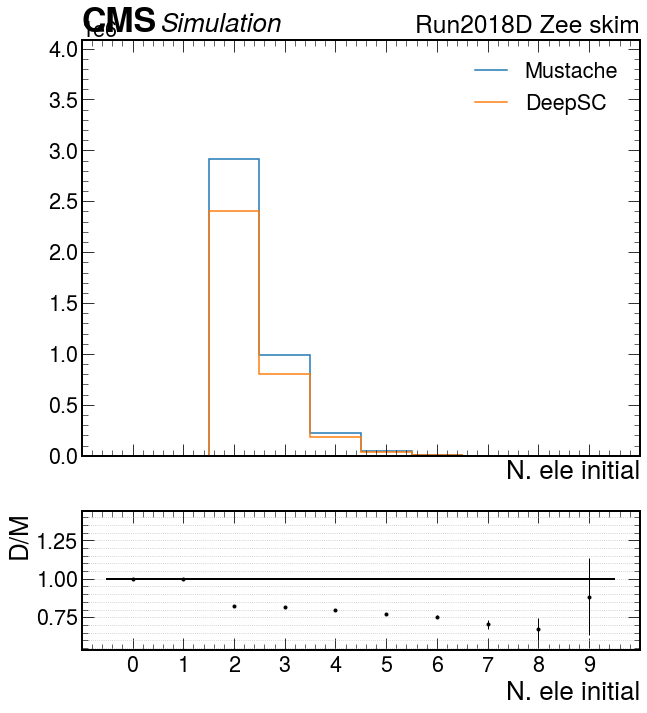

In [12]:
Hd = out["DeepSC"]["histos"]["nele_eff"].project("nele_initial")
Hm = out["Mustache"]["histos"]["nele_eff"].project("nele_initial")
plot_comparison_H(Hm, Hd, var="N_ele_initial", 
                output_folder=output_folder)

/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:98: RuntimeWarning: invalid value encountered in true_divide
  A/B,


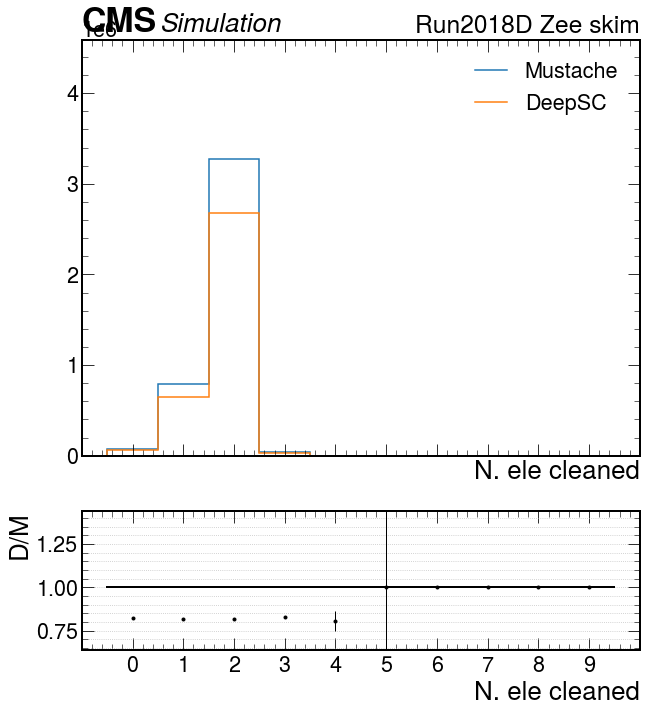

In [13]:
Hd = out["DeepSC"]["histos"]["nele_eff"].project("nele_clean")
Hm = out["Mustache"]["histos"]["nele_eff"].project("nele_clean")
plot_comparison_H(Hm, Hd, var="N_ele_clean", 
                output_folder=output_folder)

/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/1137808563.py:98: RuntimeWarning: divide by zero encountered in true_divide
  A/B,


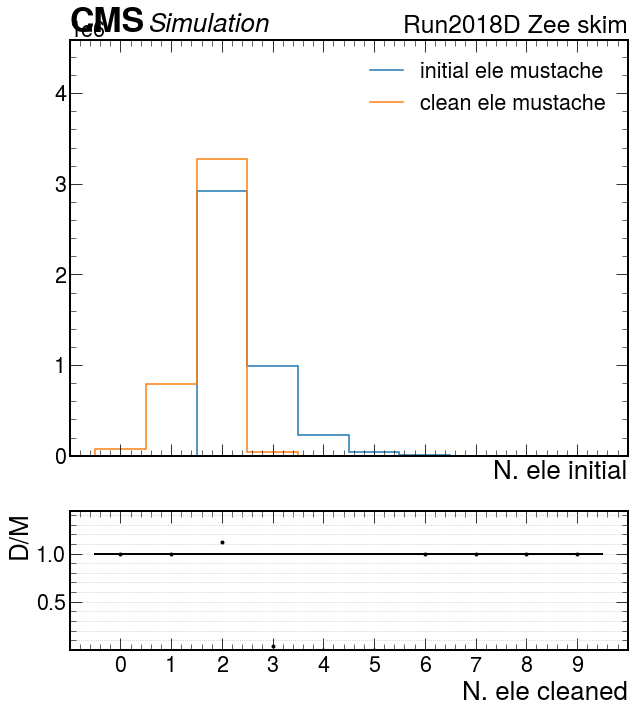

In [15]:
Hm = out["Mustache"]["histos"]["nele_eff"]
plot_comparison_H(Hm.project("nele_initial"), Hm.project("nele_clean"), var="N_ele_eff_must", 
                  legendB="initial ele mustache", legendA="clean ele mustache",
                output_folder=output_folder)

/tmp/ipykernel_8458/2429374711.py:95: RuntimeWarning: divide by zero encountered in divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_8458/2429374711.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_8458/2429374711.py:98: RuntimeWarning: divide by zero encountered in divide
  A/B,


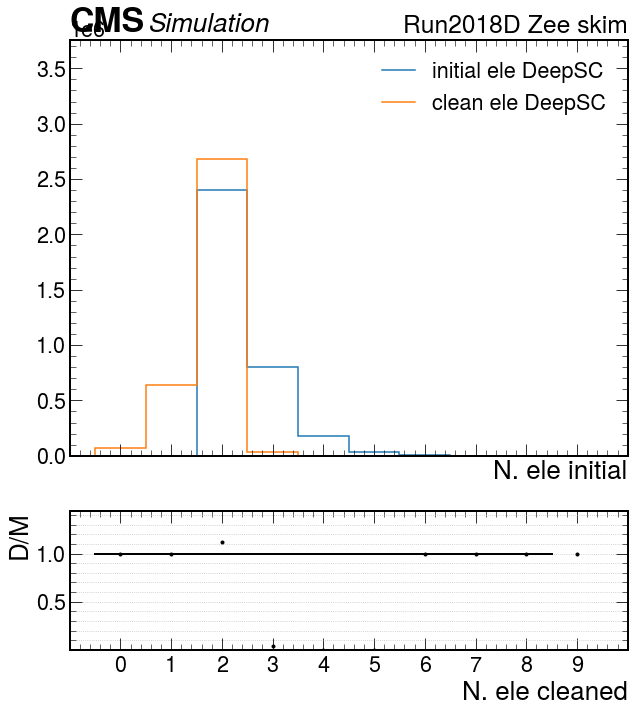

In [45]:
Hm = out["DeepSC"]["histos"]["nele_eff"]
plot_comparison_H(Hm.project("nele_initial"), Hm.project("nele_clean"), var="N_ele_eff_deepsc", 
                  legendB="initial ele DeepSC", legendA="clean ele DeepSC",
                output_folder=output_folder)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f2e73146d90>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f2e6d9e25b0>, text=[])

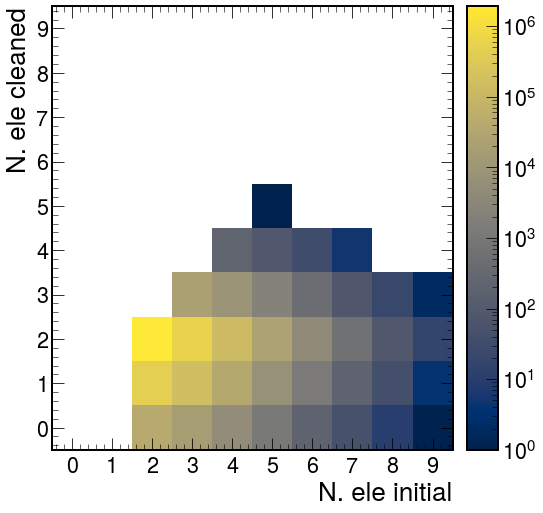

In [16]:
f = plt.figure(figsize=(8,8), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["nele_eff"], cmap="cividis", norm=LogNorm())

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f2e6d98cd30>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f2e69c4c280>, text=[])

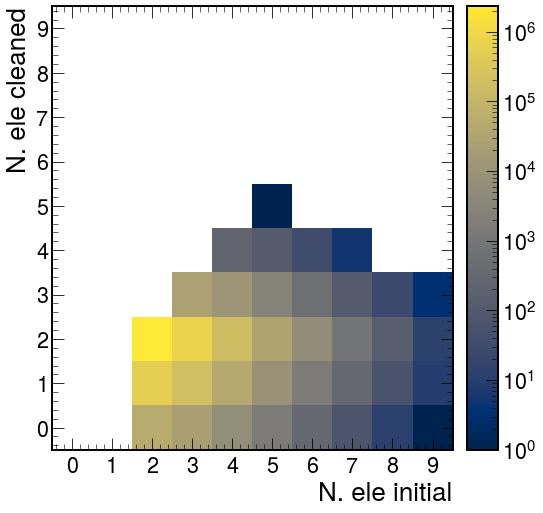

In [17]:
f = plt.figure(figsize=(8,8), dpi=72)
hep.hist2dplot(out["Mustache"]["histos"]["nele_eff"], cmap="cividis", norm=LogNorm())

Text(1, 9, 'DeepSC/Mustache')

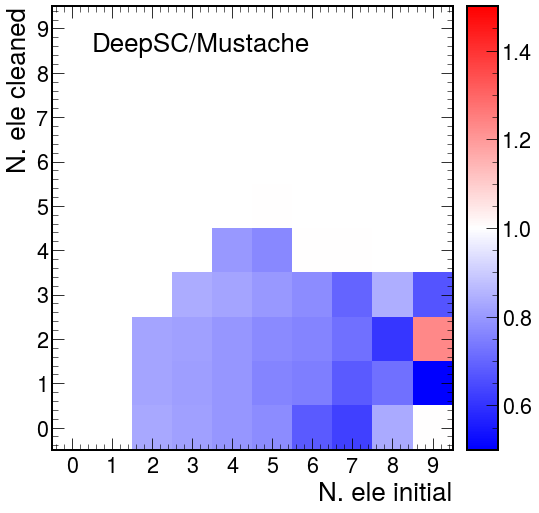

In [18]:
f = plt.figure(figsize=(8,8), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["nele_eff"]/out["Mustache"]["histos"]["nele_eff"], 
               cmap="bwr", vmin=0.5, vmax=1.5)
plt.text(1,9,"DeepSC/Mustache")

Text(1, 9, 'DeepSC/Mustache')

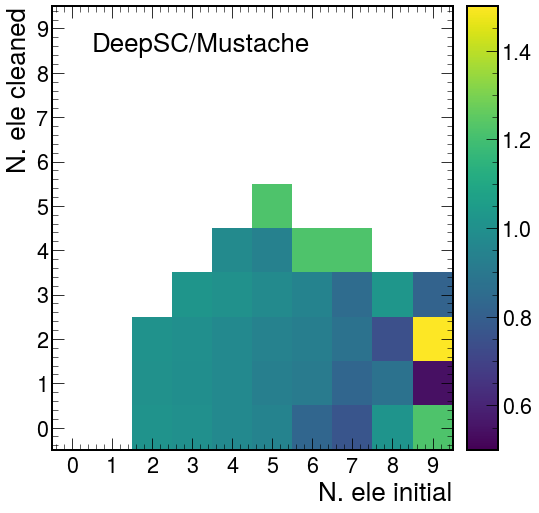

In [173]:
f = plt.figure(figsize=(8,8), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["nele_eff"]*D_ov_M/out["Mustache"]["histos"]["nele_eff"], 
               cmap="viridis", vmin=0.5, vmax=1.5)
plt.text(1,9,"DeepSC/Mustache")

## Electron plots

#### Classification

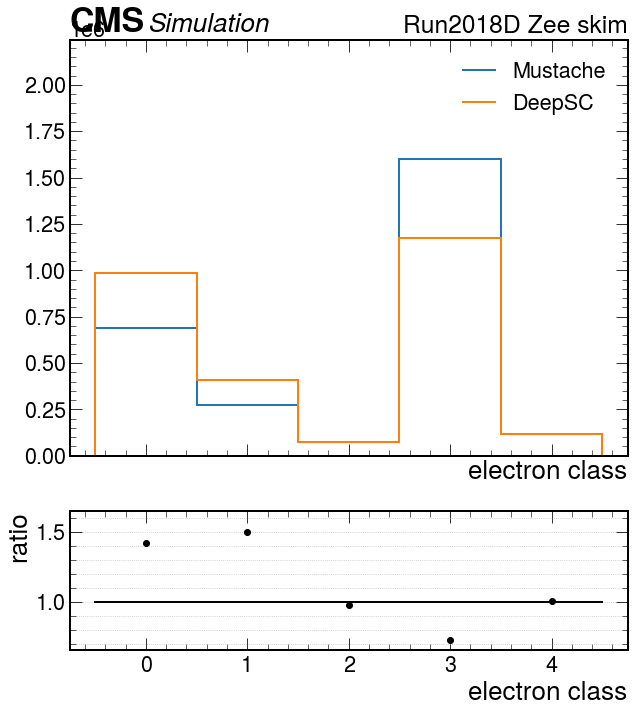

In [180]:
Hd = out["DeepSC"]["histos"]["ele_lead"].project("class")*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"].project("class")
plot_comparison_H(Hm, Hd, var="ele_class",
                output_folder=output_folder)

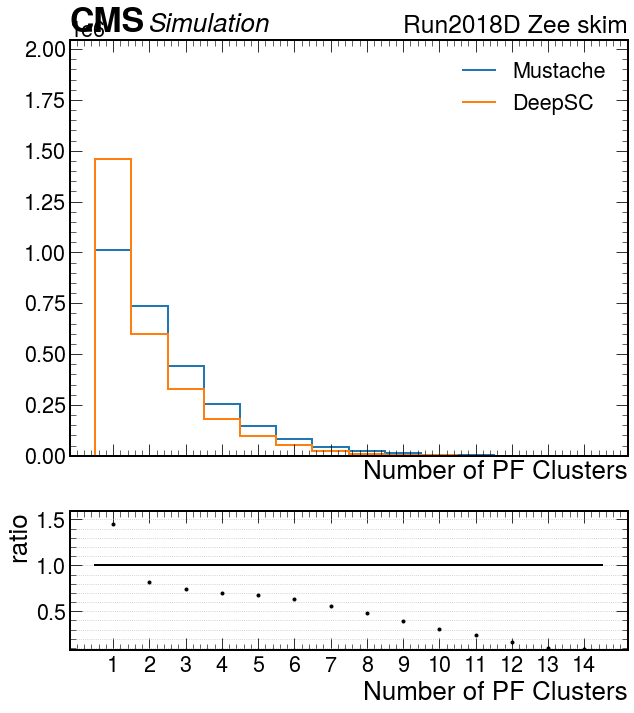

In [183]:
Hd = out["DeepSC"]["histos"]["ele_lead"].project("ncls")*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"].project("ncls")
plot_comparison_H(Hm, Hd, var="npf_cls",
                output_folder=output_folder)

/tmp/ipykernel_12955/3951626944.py:95: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:95: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:98: RuntimeWarning: invalid value encountered in true_divide
  A/B,


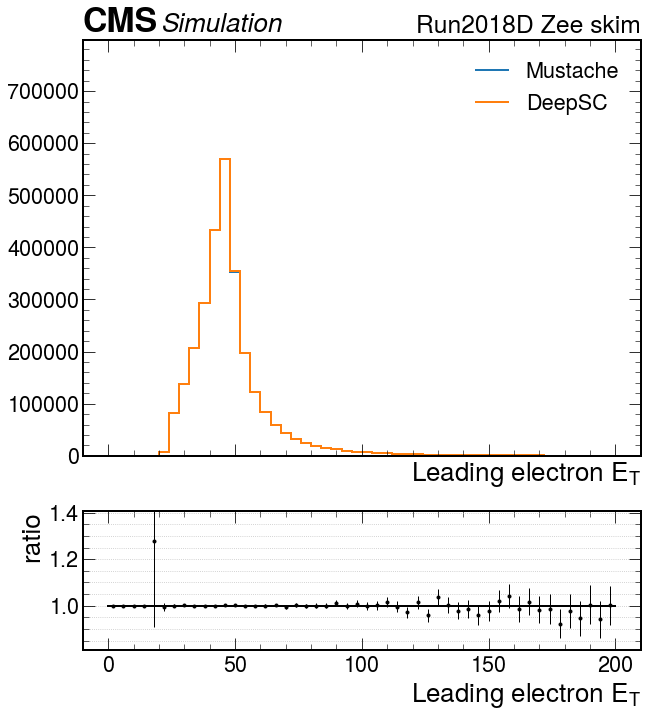

In [184]:
Hd = out["DeepSC"]["histos"]["ele_lead"].project("et")*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"].project("et")
plot_comparison_H(Hm, Hd, var="lead_ele_et",
                output_folder=output_folder)

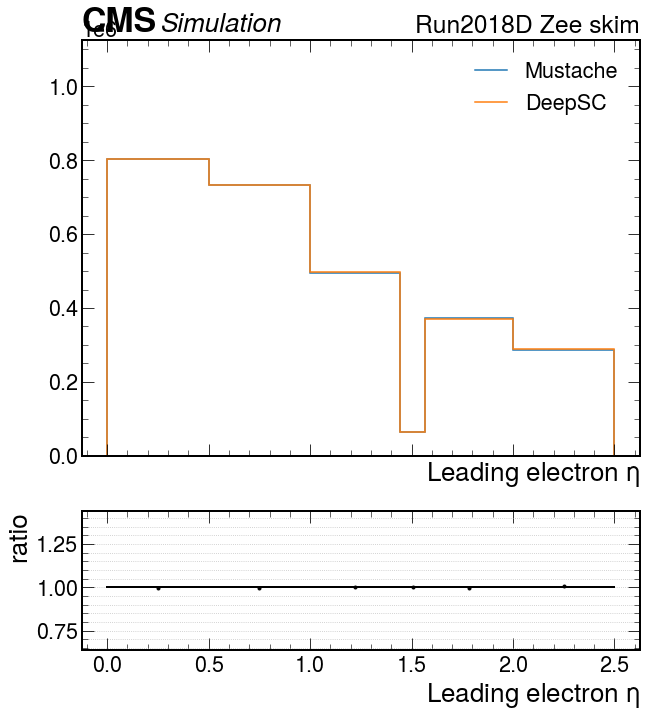

In [39]:
Hd = out["DeepSC"]["histos"]["ele_lead"].project("eta")*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"].project("eta")
plot_comparison_H(Hm, Hd, var="lead_ele_eta",
                output_folder=output_folder)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

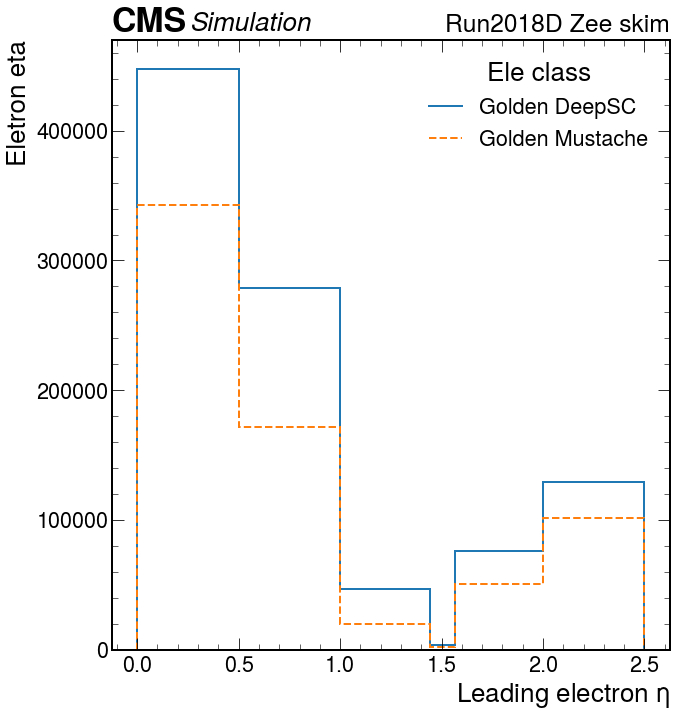

In [60]:
fig = plt.figure(figsize=(10,11), dpi=72)
Hd = out["DeepSC"]["histos"]["ele_lead"]*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"]
hep.histplot(Hd[{"class":0}].project("eta"), label="Golden DeepSC", linewidth=2)
hep.histplot(Hm[{"class":0}].project("eta"), label="Golden Mustache", linewidth=2, linestyle="dashed")

plt.legend(title="Ele class")
plt.ylabel("Eletron eta")

hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

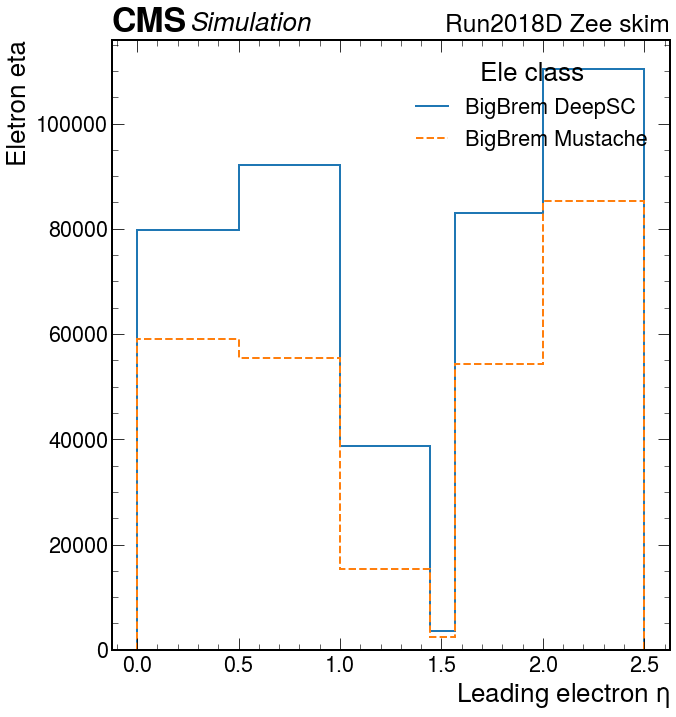

In [61]:
fig = plt.figure(figsize=(10,11), dpi=72)
Hd = out["DeepSC"]["histos"]["ele_lead"]*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"]
hep.histplot(Hd[{"class":1}].project("eta"), label="BigBrem DeepSC",linewidth=2)
hep.histplot(Hm[{"class":1}].project("eta"), label="BigBrem Mustache",linestyle="dashed",linewidth=2)

plt.legend(title="Ele class")
plt.ylabel("Eletron eta")

hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

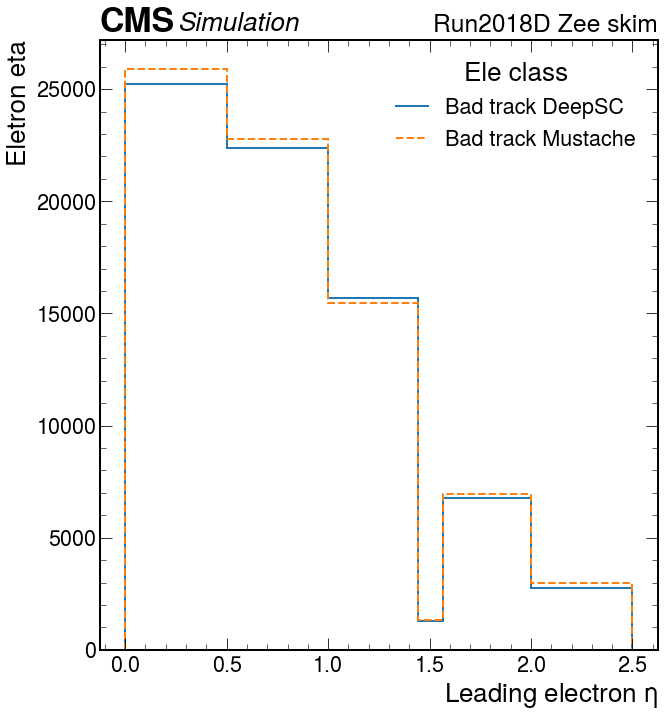

In [62]:
fig = plt.figure(figsize=(10,11), dpi=72)
Hd = out["DeepSC"]["histos"]["ele_lead"]*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"]
hep.histplot(Hd[{"class":2}].project("eta"), label="Bad track DeepSC",linewidth=2)
hep.histplot(Hm[{"class":2}].project("eta"), label="Bad track Mustache",linestyle="dashed",linewidth=2)

plt.legend(title="Ele class")
plt.ylabel("Eletron eta")


hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

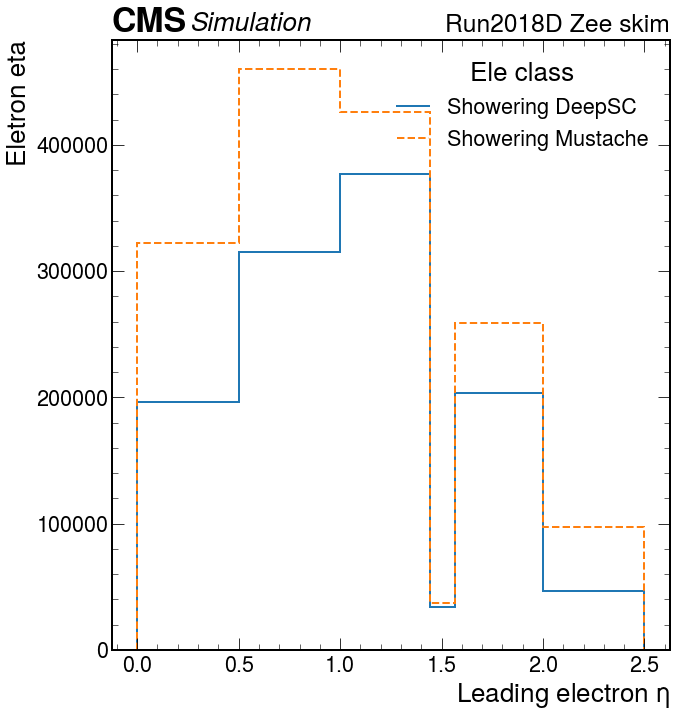

In [63]:
fig = plt.figure(figsize=(10,11), dpi=72)
Hd = out["DeepSC"]["histos"]["ele_lead"]*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"]
hep.histplot(Hd[{"class":3}].project("eta"), label="Showering DeepSC",linewidth=2)
hep.histplot(Hm[{"class":3}].project("eta"), label="Showering Mustache",linestyle="dashed",linewidth=2)

plt.legend(title="Ele class")
plt.ylabel("Eletron eta")


hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

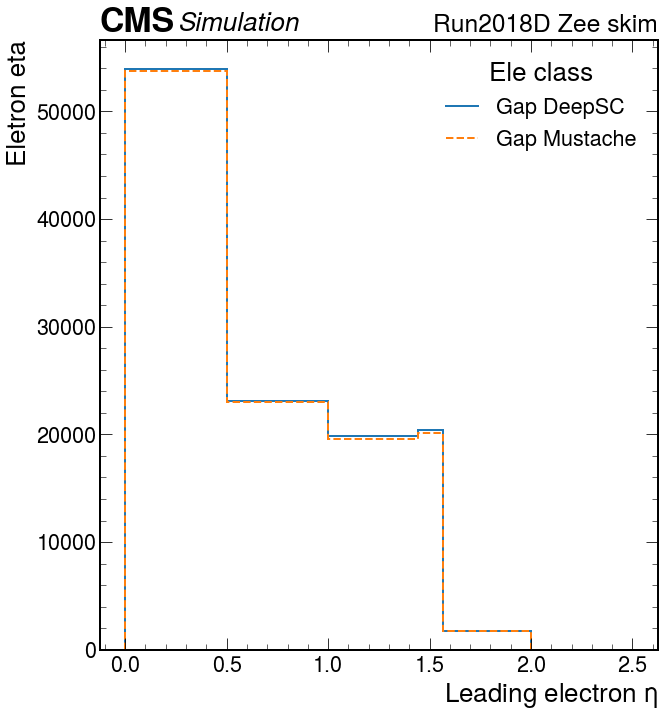

In [64]:
fig = plt.figure(figsize=(10,11), dpi=72)
Hd = out["DeepSC"]["histos"]["ele_lead"]*D_ov_M
Hm = out["Mustache"]["histos"]["ele_lead"]
hep.histplot(Hd[{"class":4}].project("eta"), label="Gap DeepSC",linewidth=2)
hep.histplot(Hm[{"class":4}].project("eta"), label="Gap Mustache",linestyle="dashed",linewidth=2)

plt.legend(title="Ele class")
plt.ylabel("Eletron eta")


hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

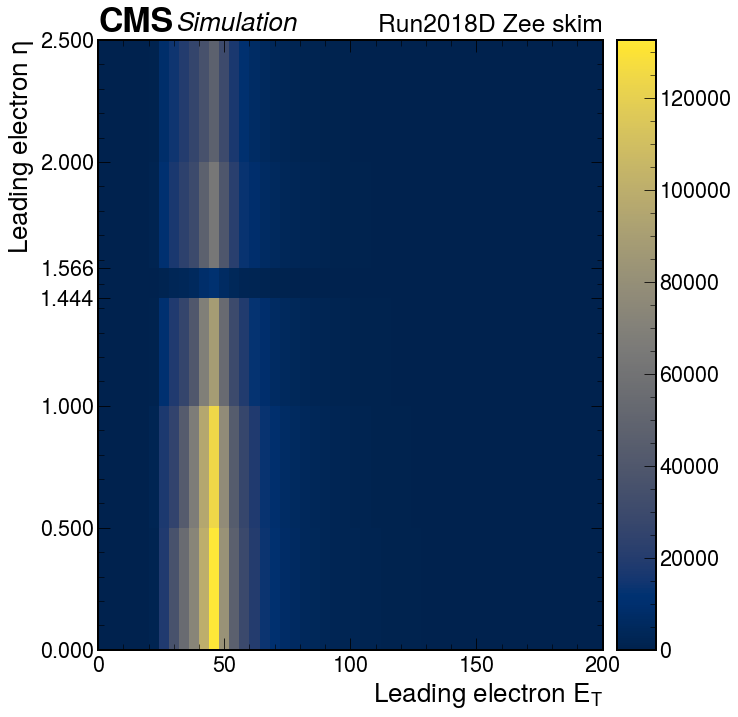

In [77]:
fig = plt.figure(figsize=(10,11), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["ele_lead"][{"class":sum, "ncls":sum}], cmap="cividis")
hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

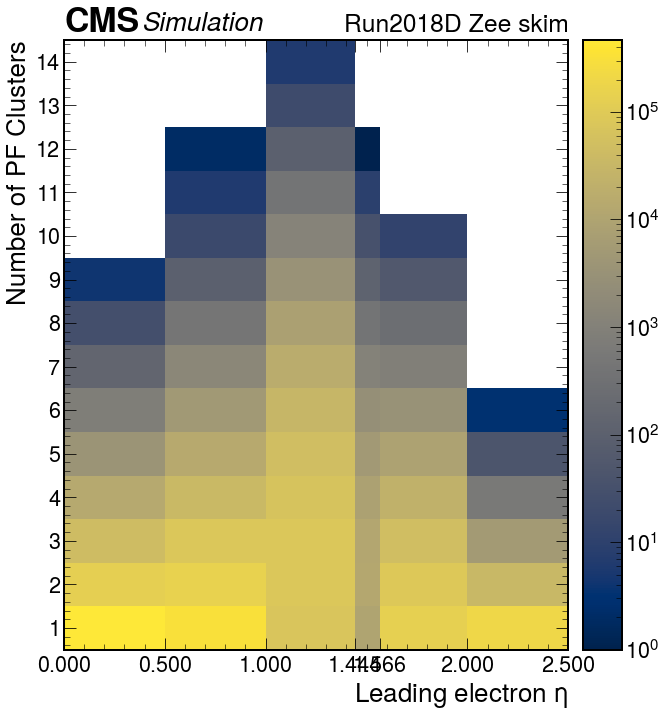

In [79]:
fig = plt.figure(figsize=(10,11), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["ele_lead"][{"class":sum, "et":sum}], cmap="cividis", norm=LogNorm())
hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation'))

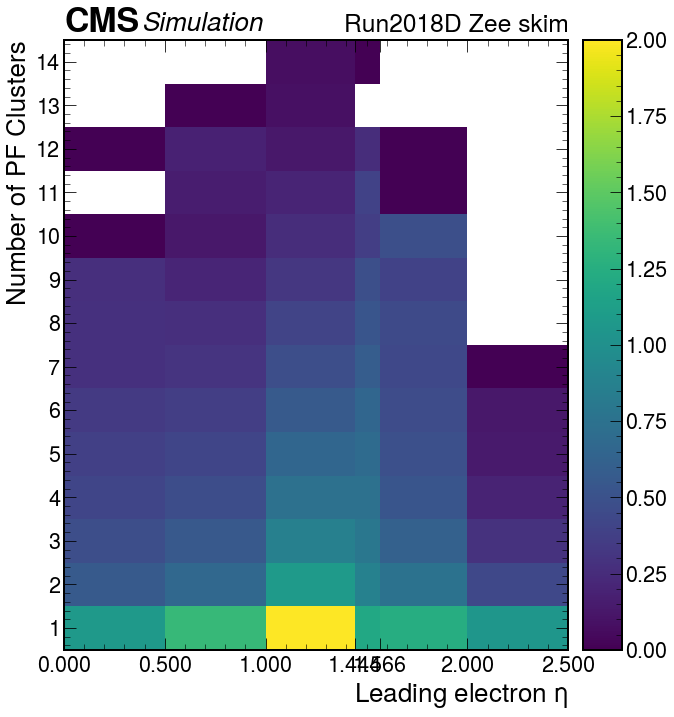

In [188]:
fig = plt.figure(figsize=(10,11), dpi=72)
hep.hist2dplot(out["DeepSC"]["histos"]["ele_lead"][{"class":sum, "et":sum}]/out["Mustache"]["histos"]["ele_lead"][{"class":sum, "et":sum}], 
               cmap="viridis", vmin=0, vmax=2)
hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

# Study the Z

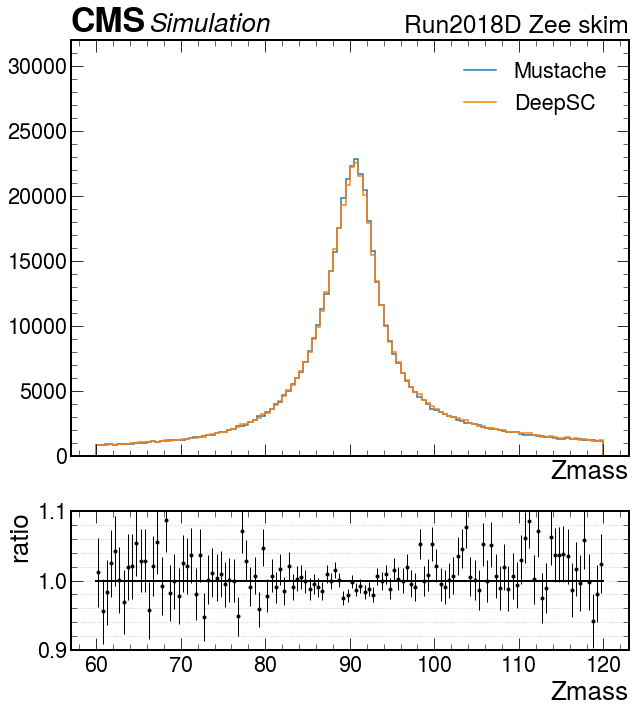

In [120]:
H_M = out["Mustache"]["histos"]["Z"][{"class":0}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"class":0}].project("zmass")*D_ov_M
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_golden", output_folder=output_folder)

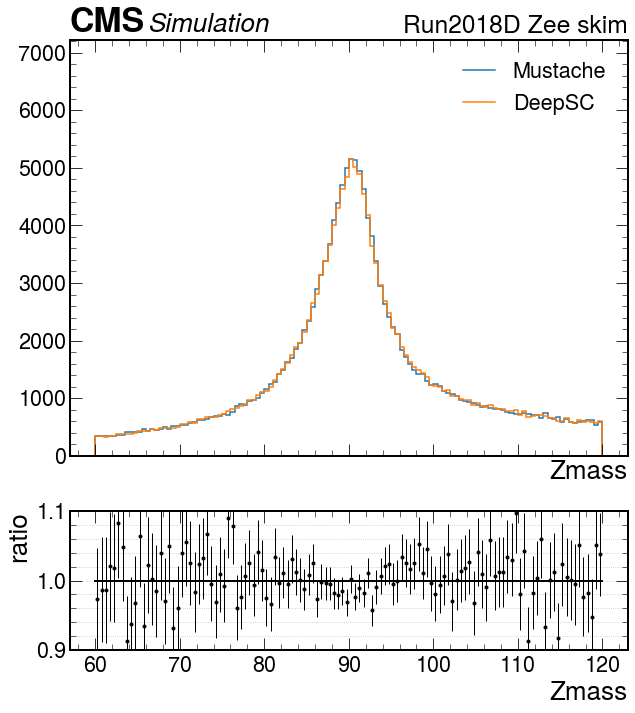

In [121]:
H_M = out["Mustache"]["histos"]["Z"][{"class":1}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"class":1}].project("zmass")*D_ov_M
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_bigbrem", output_folder=output_folder)

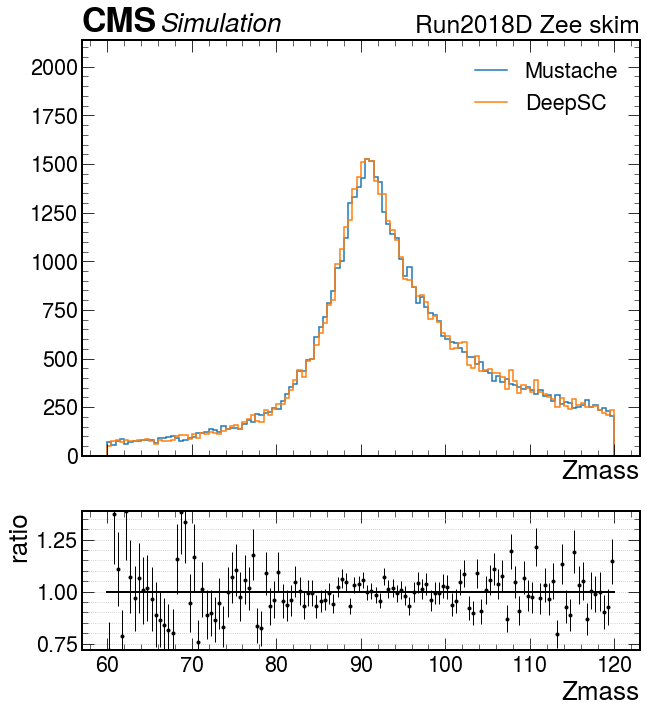

In [122]:
H_M = out["Mustache"]["histos"]["Z"][{"class":2}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"class":2}].project("zmass")*D_ov_M
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_badtrack", output_folder=output_folder)

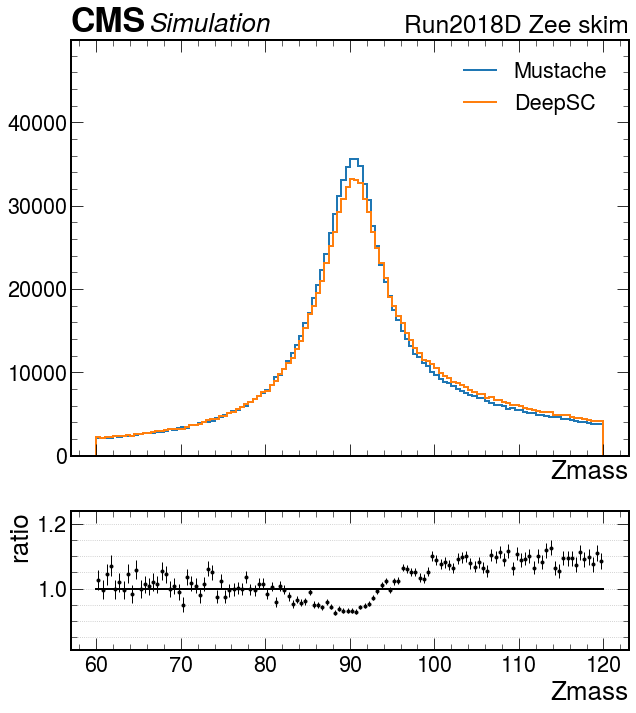

In [192]:
H_M = out["Mustache"]["histos"]["Z"][{"class":3}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"class":3}].project("zmass")*D_ov_M
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_showering", output_folder=output_folder)

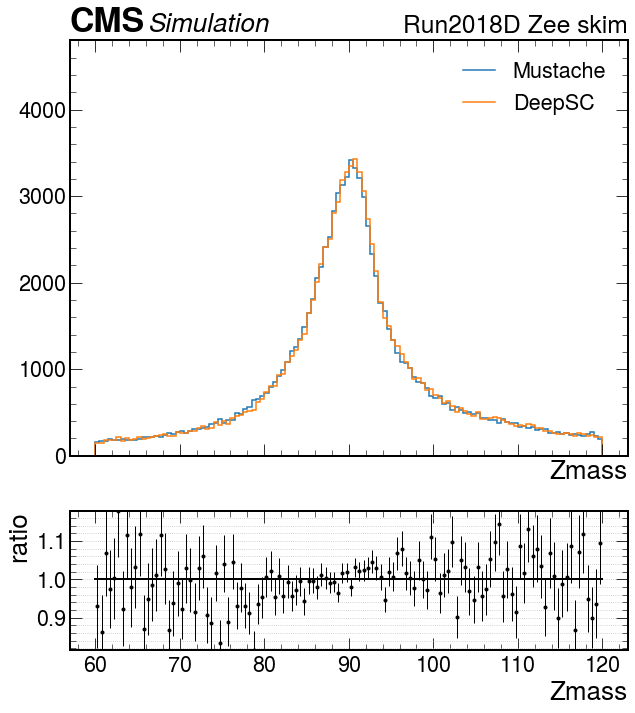

In [125]:
H_M = out["Mustache"]["histos"]["Z"][{"class":4}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"class":4}].project("zmass")*D_ov_M
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_gap", output_folder=output_folder)

### Going deeper looking at the PU

In [89]:
H_M = out["Mustache"]["histos"]["Z"]
H_D = out["DeepSC"]["histos"]["Z"]

H_M.axes["eta"].label="Leading electron $\eta$"
H_D.axes["eta"].label="Leading electron $\eta$"
H_M.axes["rho"].label="rho"
H_D.axes["rho"].label="rho"

In [86]:
H_D

Hist(
  Regular(120, 60, 120, name='zmass', label='Zmass'),
  Regular(30, 0, 200, name='et', label='Leading electron $E_T$'),
  Variable([0, 0.5, 1, 1.4442, 1.566, 2, 2.5], name='eta', label='Leading electron $\\eta$'),
  Integer(1, 15, name='ncls', label='Number of PF Clusters'),
  Regular(30, 0, 70, name='rho', label='$\rho$'),
  IntCategory([0, 1, 2, 3, 4], name='class', label='electron class'),
  storage=Double()) # Sum: 1664434.0 (2259418.0 with flow)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

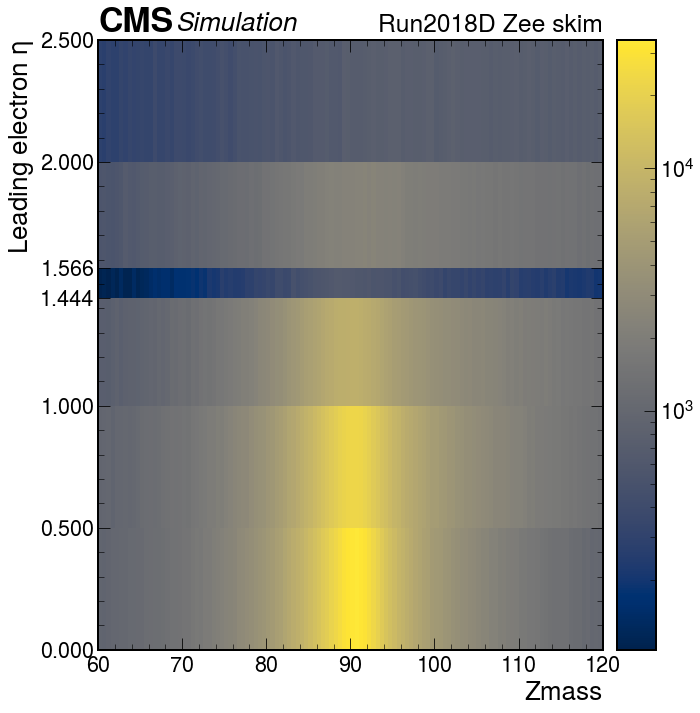

In [92]:
fig = plt.figure(figsize=(10,11), dpi=72)
hep.hist2dplot(H_M[{"class":sum, "et":sum, "rho":sum,"ncls":sum}], cmap="cividis", norm=LogNorm())
hep.cms.label(rlabel="Run2018D Zee skim", loc=0, ax=plt.gca())

### Mass peak by rho

/tmp/ipykernel_12955/564978946.py:95: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/564978946.py:95: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/564978946.py:95: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/564978946.py:98: RuntimeWarning: invalid value encountered in true_divide
  A/B,


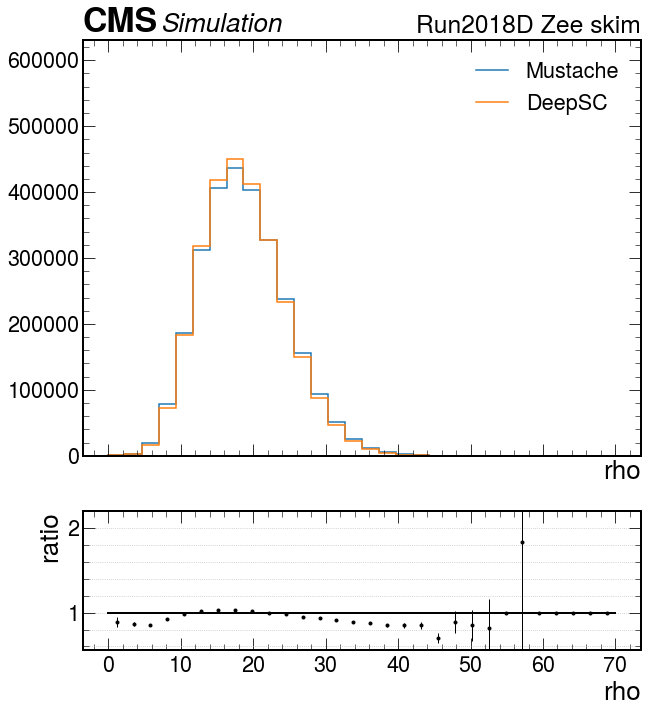

In [104]:
H_M = out["Mustache"]["histos"]["Z"].project("rho")
H_D = out["DeepSC"]["histos"]["Z"].project("rho")*D_ov_M
                                                        
#dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D, var="rho", output_folder=output_folder)

In [101]:
out["Mustache"]["histos"]["`Z"]

Hist(
  Regular(120, 60, 120, name='zmass', label='Zmass'),
  Regular(30, 0, 200, name='et', label='Leading electron $E_T$'),
  Variable([0, 0.5, 1, 1.4442, 1.566, 2, 2.5], name='eta', label='Leading electron $\\eta$'),
  Integer(1, 15, name='ncls', label='Number of PF Clusters'),
  Regular(30, 0, 70, name='rho'),
  IntCategory([0, 1, 2, 3, 4], name='class', label='electron class'),
  storage=Double()) # Sum: 2033201.0 (2757796.0 with flow)

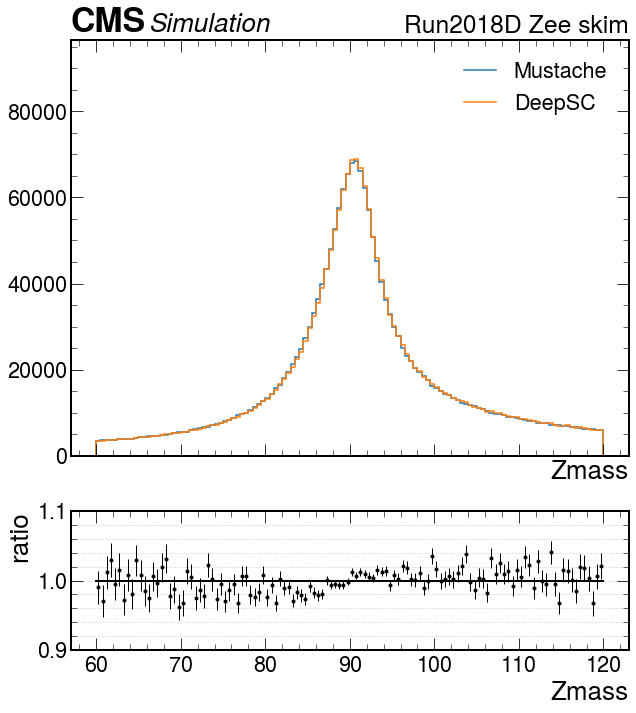

In [114]:
H_M = out["Mustache"]["histos"]["Z"][{"rho":slice(15j, 25j)}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"rho":slice(15j, 25j)}].project("zmass")
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_rho_15_25", output_folder=output_folder)

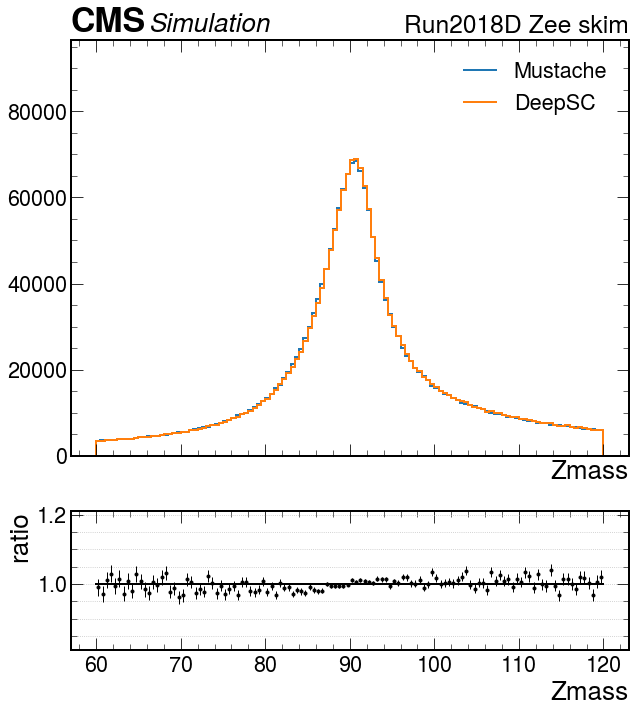

In [190]:
H_M = out["Mustache"]["histos"]["Z"][{"rho":slice(0j, 40j)}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"rho":slice(0j, 40j)}].project("zmass")
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_rho_0_40", output_folder=output_folder)

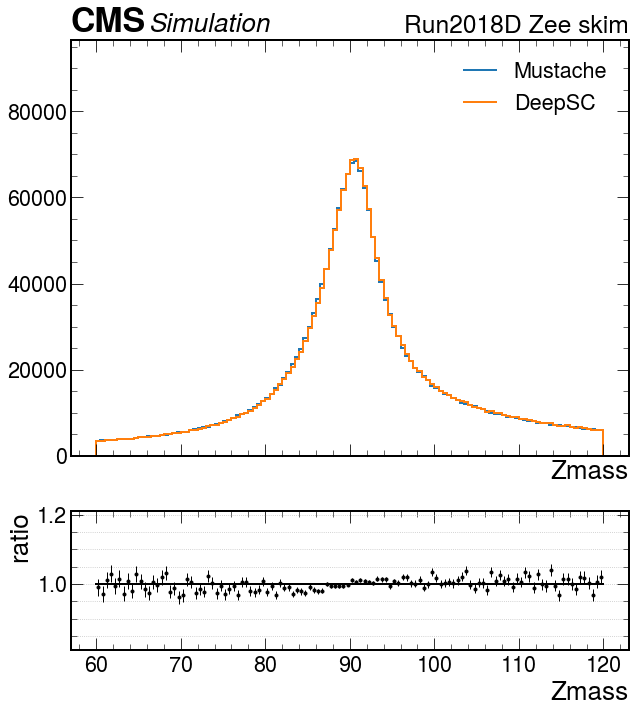

In [191]:
H_M = out["Mustache"]["histos"]["Z"][{"rho":slice(40j,70j)}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"rho":slice(40j,70j)}].project("zmass")
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_rho_40_70", output_folder=output_folder)

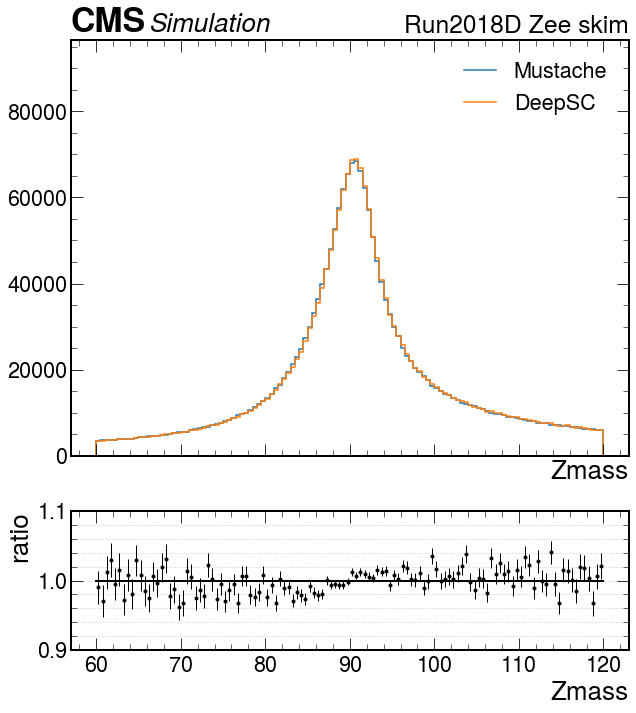

In [113]:
H_M = out["Mustache"]["histos"]["Z"][{"rho":slice(0j,15j)}].project("zmass")
H_D = out["DeepSC"]["histos"]["Z"][{"rho":slice(0j,15j)}].project("zmass")
                                                        
dovm = np.sum(H_M.values())/  np.sum(H_D.values())

plot_comparison_H(H_M,H_D*dovm, var="Z_mass_rho_15low", output_folder=output_folder)

### Mass peak by eta and class

In [130]:
ZH = out["Mustache"]["histos"]["Z"]
ZH

Hist(
  Regular(120, 60, 120, name='zmass', label='Zmass'),
  Regular(30, 0, 200, name='et', label='Leading electron $E_T$'),
  Variable([0, 0.5, 1, 1.4442, 1.566, 2, 2.5], name='eta', label='Leading electron $\\eta$'),
  Integer(1, 15, name='ncls', label='Number of PF Clusters'),
  Regular(30, 0, 70, name='rho'),
  IntCategory([0, 1, 2, 3, 4], name='class', label='electron class'),
  storage=Double()) # Sum: 2033201.0 (2757796.0 with flow)

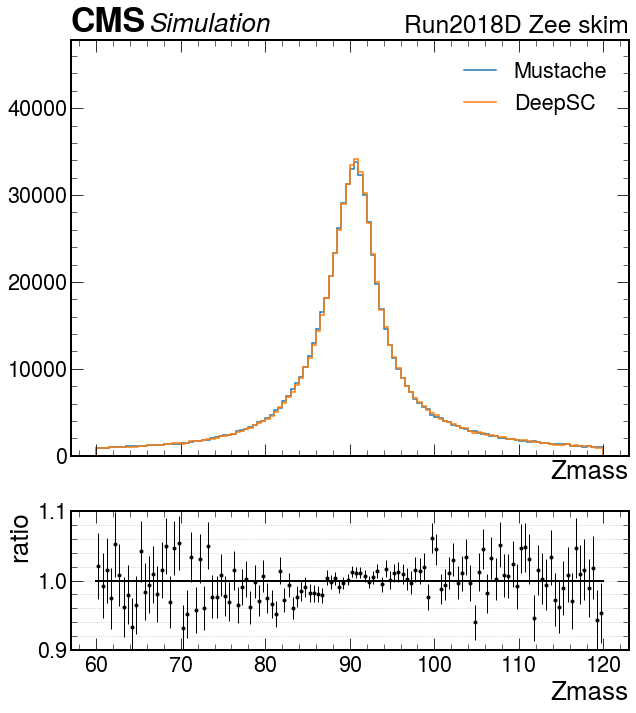

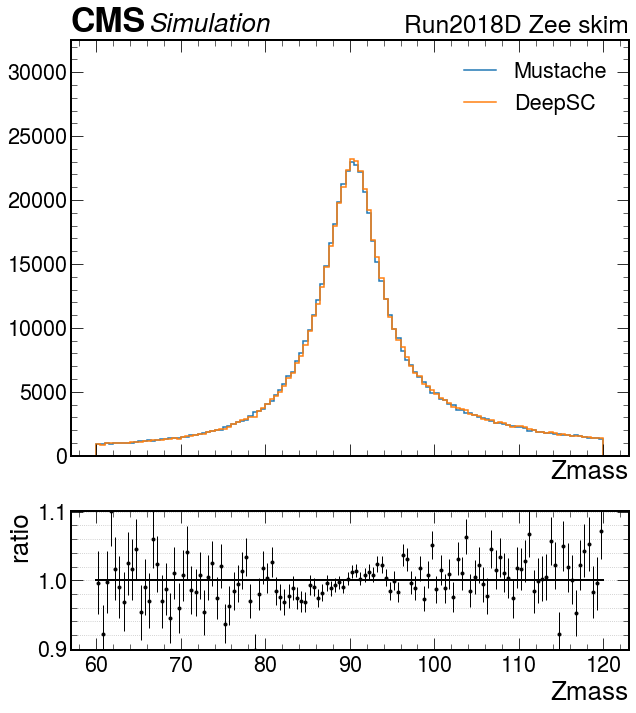

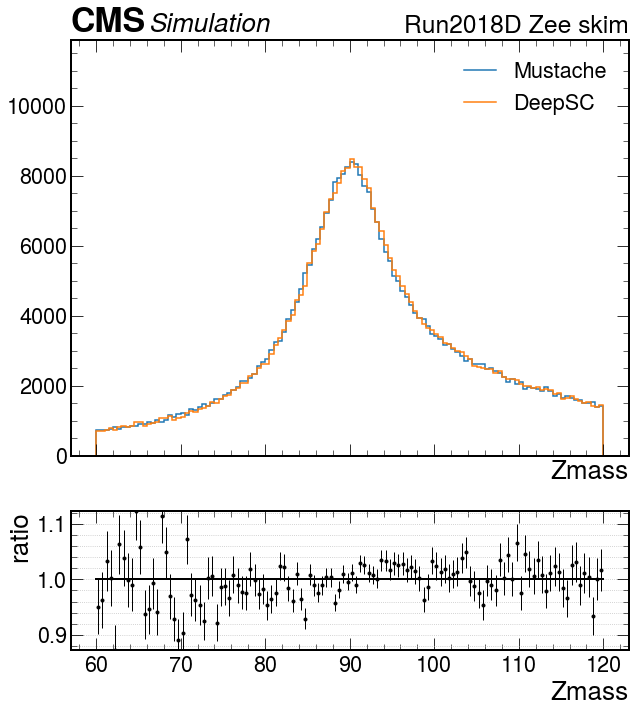

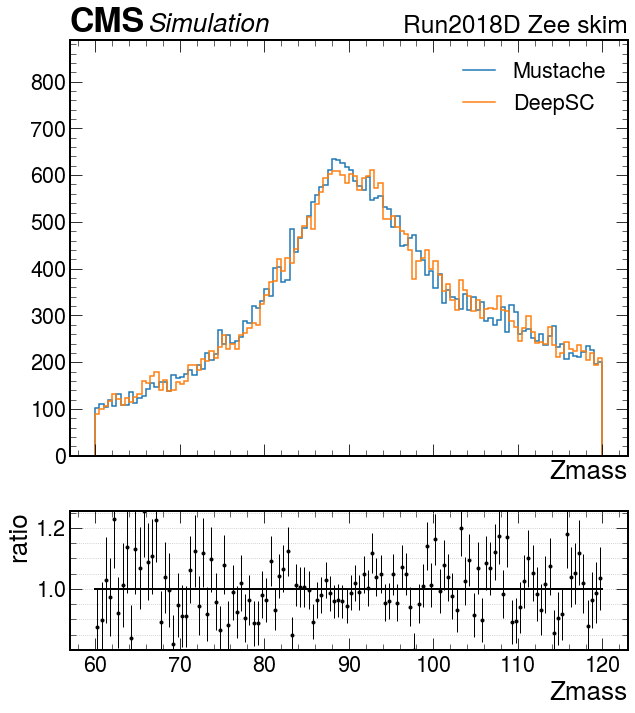

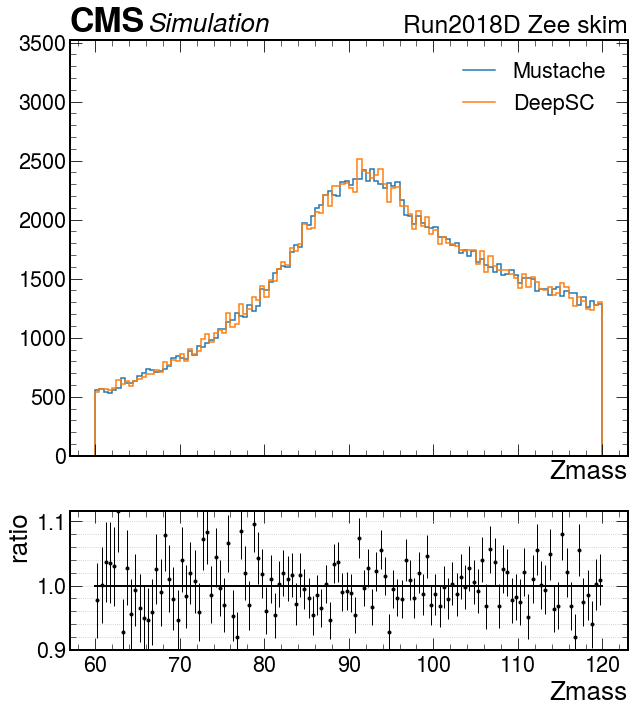

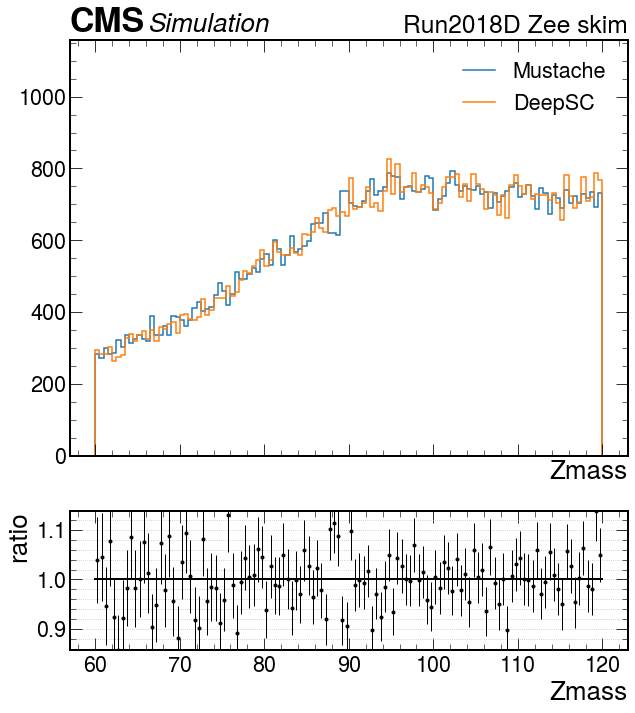

In [131]:
for ieta in range(6):
    H_M = out["Mustache"]["histos"]["Z"][{"eta":ieta}].project("zmass")
    H_D = out["DeepSC"]["histos"]["Z"][{"eta":ieta}].project("zmass")

    dovm = np.sum(H_M.values())/  np.sum(H_D.values())

    plot_comparison_H(H_M,H_D*dovm, var=f"Z_mass_eta_{ZH.axes[0][ieta]}_{ZH.axes[0][ieta+1]}", output_folder=output_folder)

In [152]:
H_M

0          102.890564
1           91.826904
9           87.522133
10          95.972389
19          65.401886
              ...    
2757776     90.537422
2757783     93.162903
2757790    109.667313
2757791     99.847992
2757793     88.768745
Name: mass, Length: 804069, dtype: float32

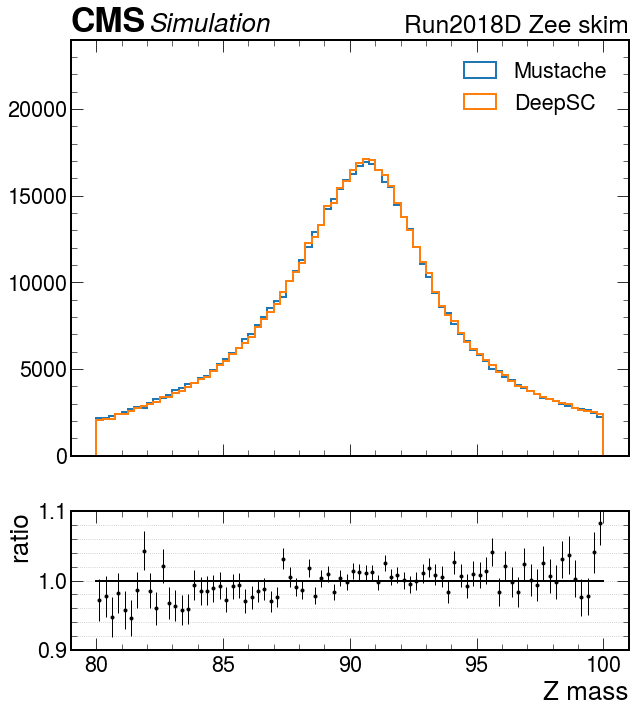

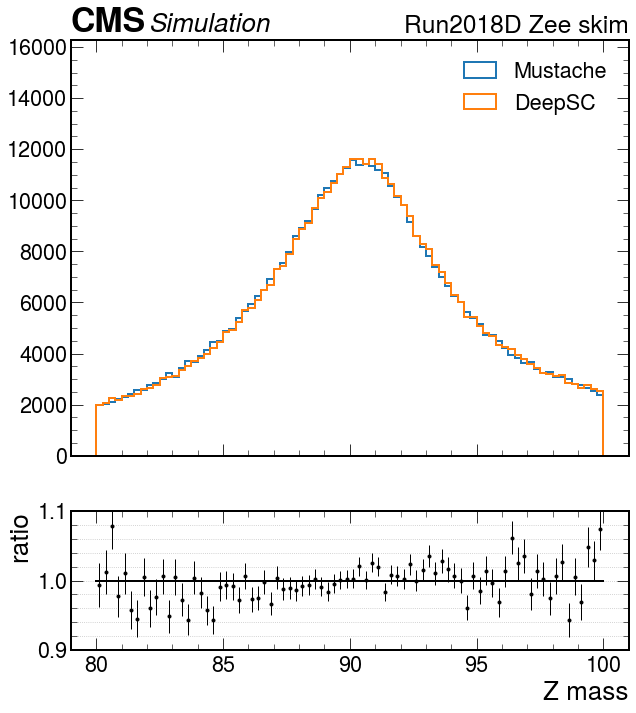

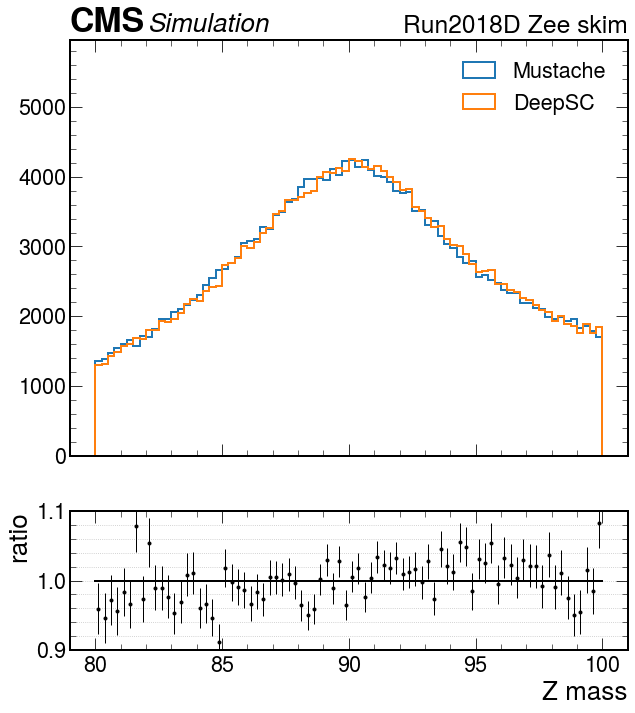

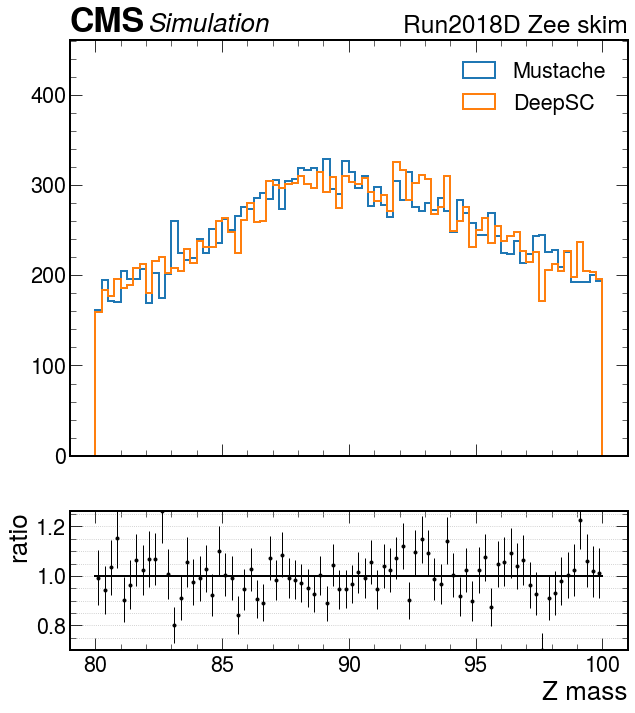

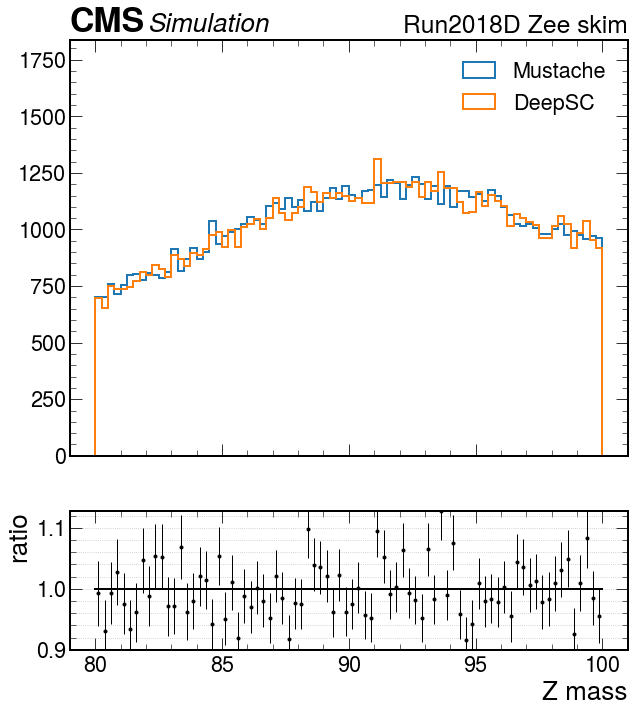

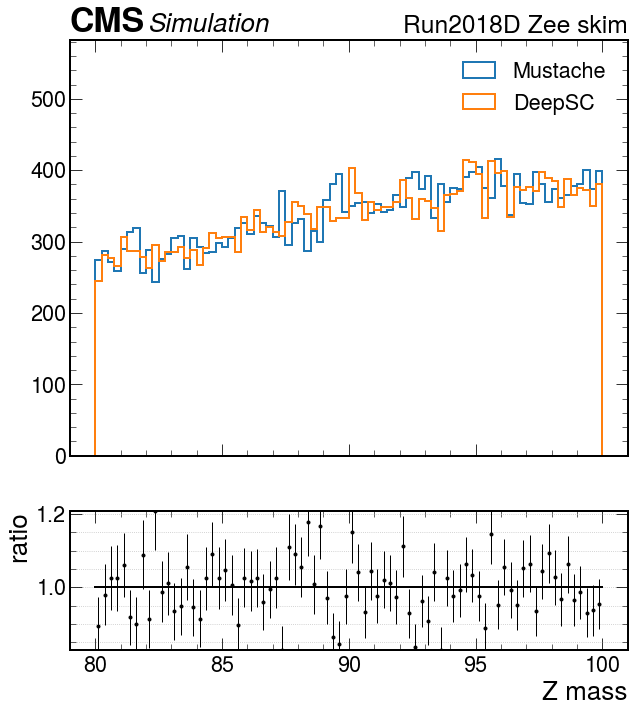

In [156]:
etas = [0, 0.5, 1, 1.4442, 1.566, 2, 2.5]

for ieta in range(len(etas)-1):
    H_M = Zm[(abs(Zm.ele_eta)>etas[ieta])&(abs(Zm.ele_eta)<etas[ieta+1])].mass
    H_D = Zd[(abs(Zd.ele_eta)>etas[ieta])&(abs(Zd.ele_eta)<etas[ieta+1])].mass

    plot_comparison(H_M,H_D, var=f"Z_mass_eta_{ZH.axes[0][ieta]}_{ZH.axes[0][ieta+1]}", output_folder=output_folder,
                      bins=80, xrange=(80,100), label="Z mass", wA= np.ones(len(H_D))*len(H_M)/len(H_D) )

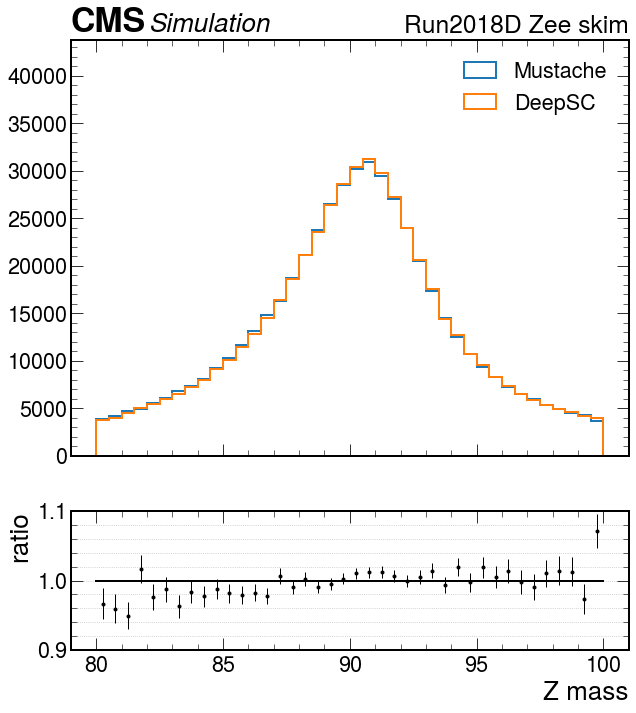

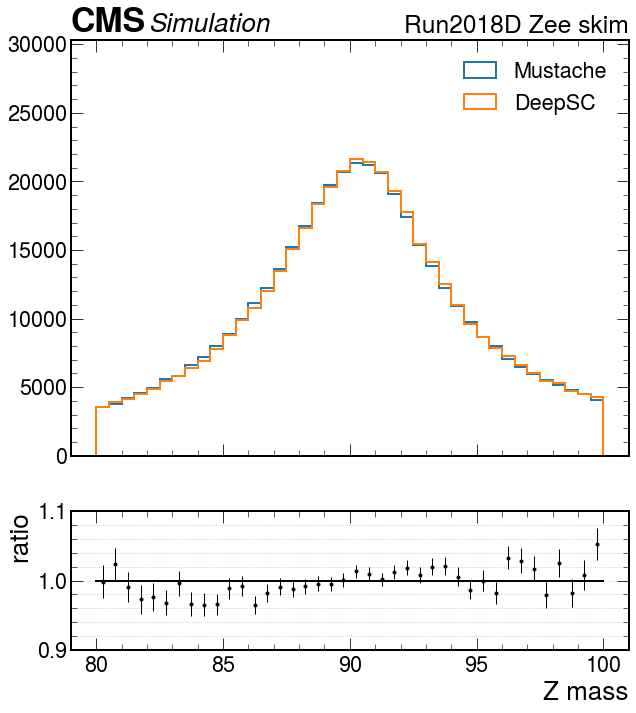

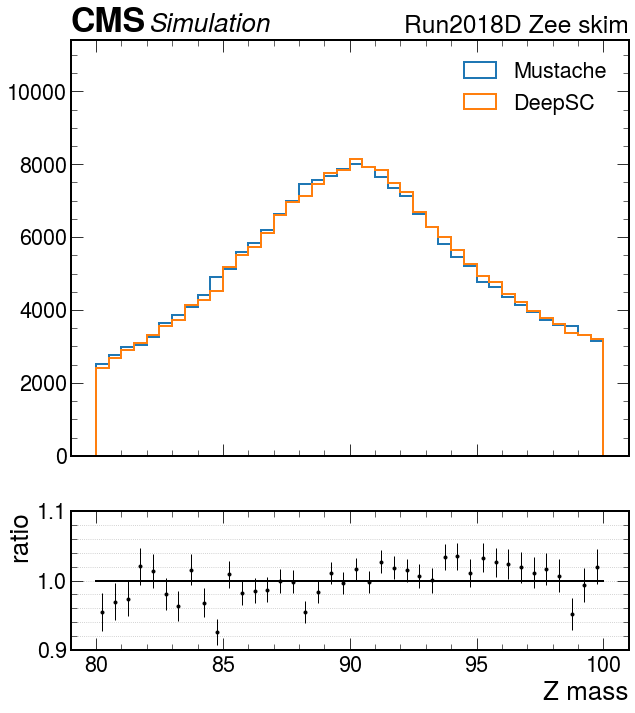

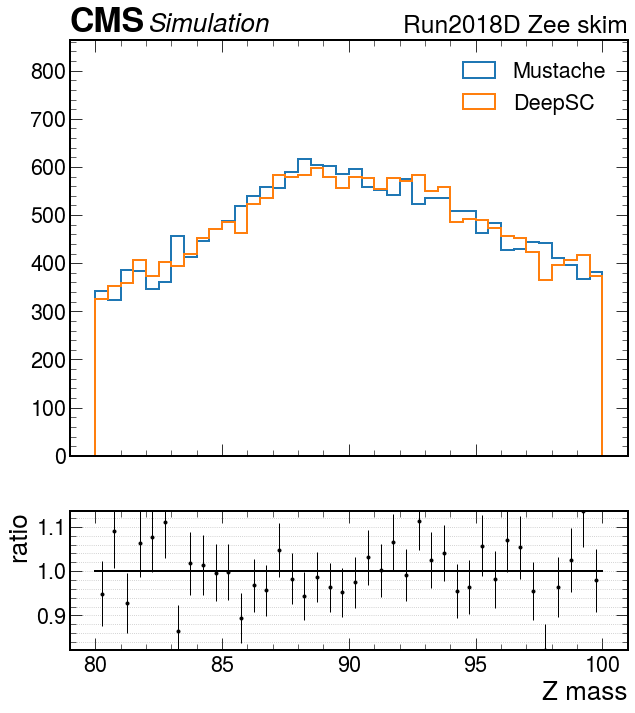

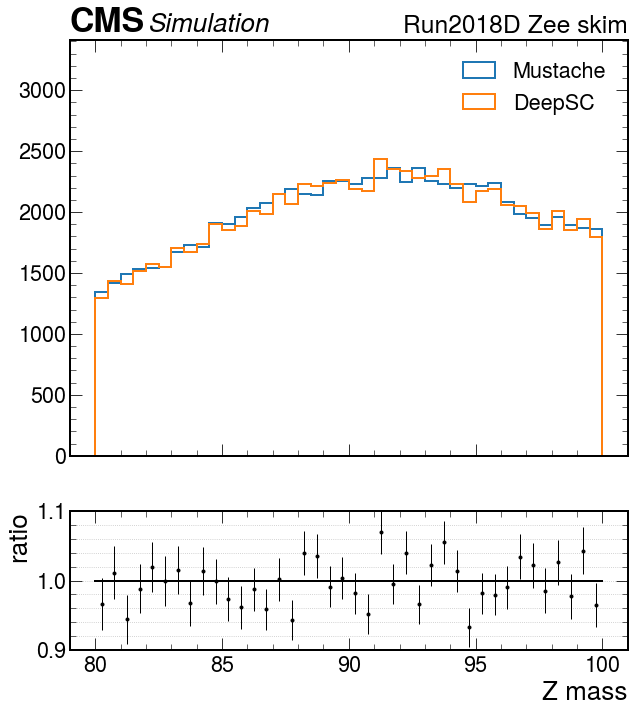

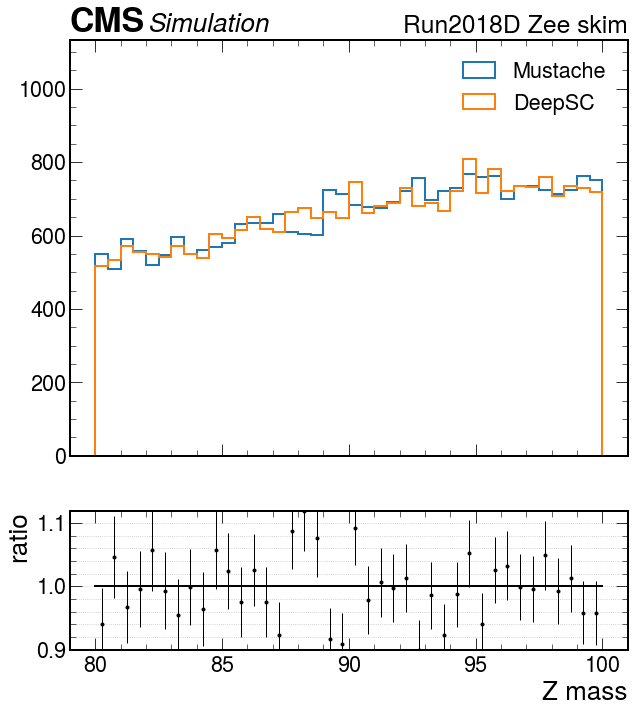

In [159]:
etas = [0, 0.5, 1, 1.4442, 1.566, 2, 2.5]

for ieta in range(len(etas)-1):
    H_M = Zm[(abs(Zm.ele_eta)>etas[ieta])&(abs(Zm.ele_eta)<etas[ieta+1])&(Zm.ele_et < 60)].mass
    H_D = Zd[(abs(Zd.ele_eta)>etas[ieta])&(abs(Zd.ele_eta)<etas[ieta+1])&(Zd.ele_et < 60)].mass

    plot_comparison(H_M,H_D, var=f"Z_mass_eta_{ZH.axes[0][ieta]}_{ZH.axes[0][ieta+1]}_eleet_20_60", output_folder=output_folder,
                      bins=40, xrange=(80,100), label="Z mass", wA= np.ones(len(H_D))*len(H_M)/len(H_D) )

In [162]:
Zm

,ele_eta,mass,ele_et,r9,nvtx,ele_class,rho,ele_eta_bin,ele_et_bin
0,0.108496,102.890564,32.488907,0.946306,36,3,19.561445,0,1
1,0.010547,91.826904,41.667603,0.997720,31,0,25.562391,0,2
2,2.486633,157.666992,40.526669,0.991934,22,1,17.672285,5,2
3,2.441360,229.449066,40.835987,1.000716,20,0,15.906266,5,2
4,1.870251,299.550171,73.279114,0.972651,20,1,13.504101,4,3
...,...,...,...,...,...,...,...,...,...
2757791,-0.224917,99.847992,217.387207,0.958393,34,0,25.198494,0,NaN
2757792,-1.294590,88.956627,43.903740,0.573559,41,3,28.362663,2,2
2757793,0.442682,88.768745,44.129726,0.774813,35,3,24.362032,0,2
2757794,1.697847,127.916870,59.261810,0.835378,32,3,22.317822,4,2


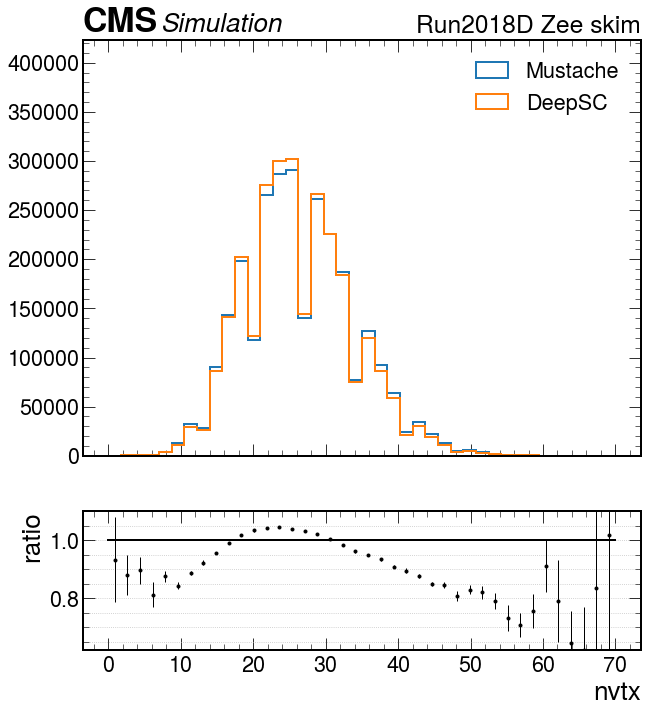

In [167]:
plot_comparison(Zm.nvtx,Zd.nvtx, var=f"nvtx", output_folder=output_folder,
                  bins=40, xrange=(0,70), label="nvtx" , wA= np.ones(len(Zd.nvtx))*D_ov_M)

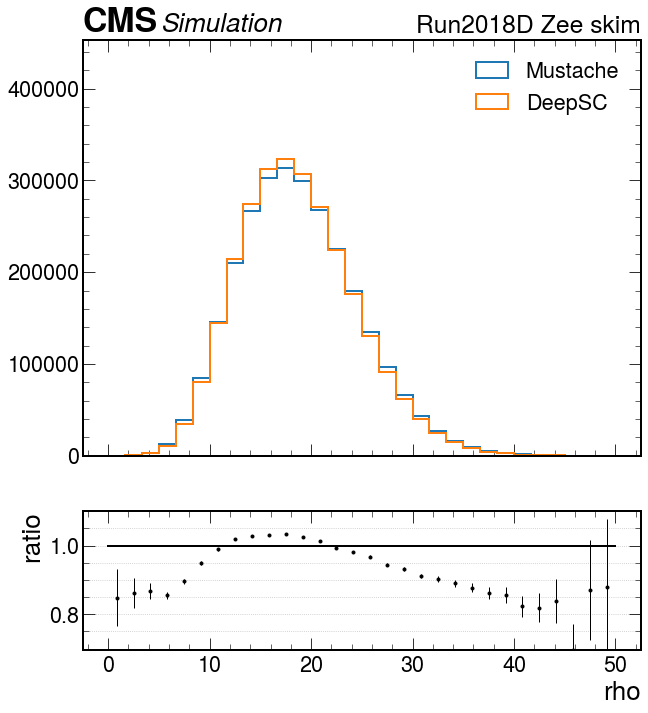

In [170]:
plot_comparison(Zm.rho,Zd.rho, var=f"rho", output_folder=output_folder,
                  bins=30, xrange=(0,50), label="rho" , wA= np.ones(len(Zd.rho))*D_ov_M)

# Category by R9

/tmp/ipykernel_12955/3951626944.py:39: RuntimeWarning: divide by zero encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:39: RuntimeWarning: invalid value encountered in multiply
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:39: RuntimeWarning: invalid value encountered in true_divide
  errR = np.sqrt( errA**2 * (1/B)**2 + errB**2 *(A/B**2)**2)
/tmp/ipykernel_12955/3951626944.py:42: RuntimeWarning: invalid value encountered in true_divide
  A/B,


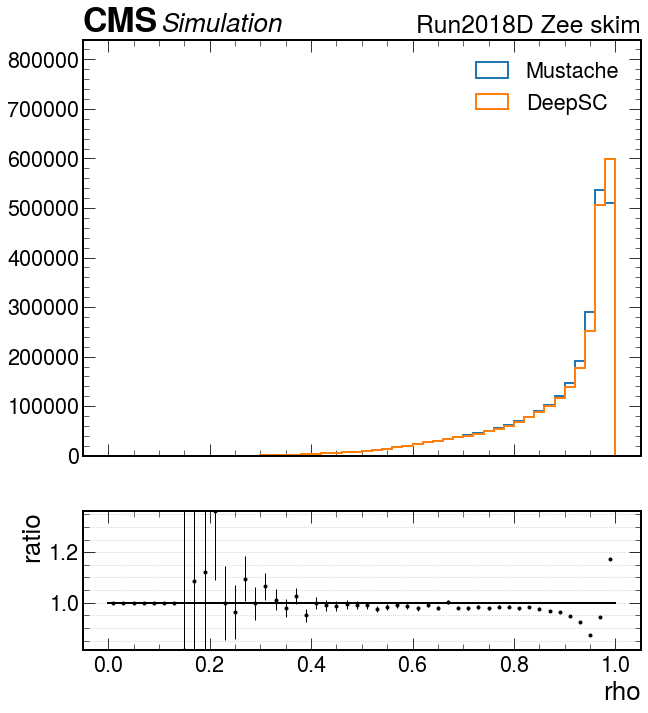

In [195]:
plot_comparison(Zm.r9,Zd.r9, var=f"R9", output_folder=output_folder,
                  bins=50, xrange=(0,1), label="rho" , wA= np.ones(len(Zd.r9))*D_ov_M)

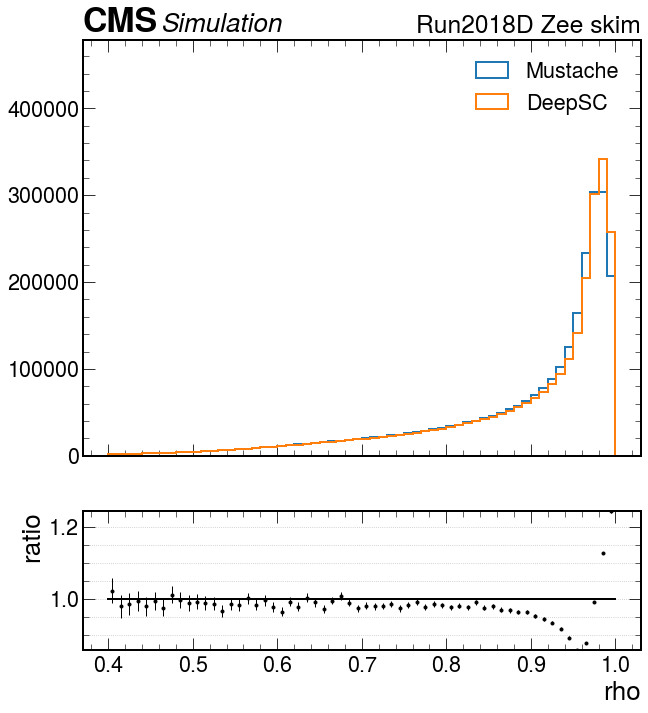

In [196]:
plot_comparison(Zm.r9,Zd.r9, var=f"R9", output_folder=output_folder,
                  bins=60, xrange=(0.4,1), label="rho" , wA= np.ones(len(Zd.r9))*D_ov_M)

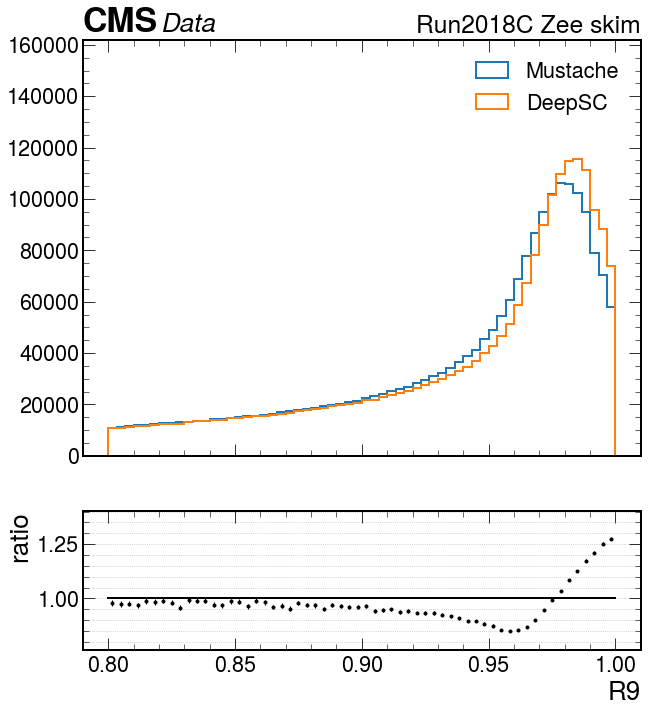

In [202]:
plot_comparison(Zm.r9,Zd.r9, var=f"R9", output_folder=output_folder,
                  bins=60, xrange=(0.8,1), label="R9" , wA= np.ones(len(Zd.r9))*D_ov_M)

In [207]:
Hd = Zd[Zd.r9<0.95].mass

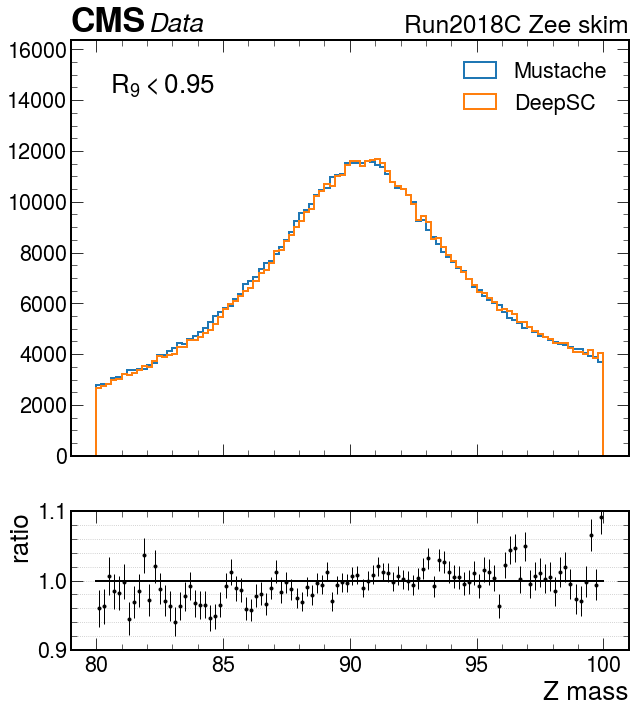

In [225]:
Hm = Zm[Zm.r9<0.95].mass
Hd = Zd[Zd.r9<0.95].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95", 
                output_folder=output_folder,
                bins=100, xrange=(80,100), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$",
               ratio_lim=(0.9,1.1))


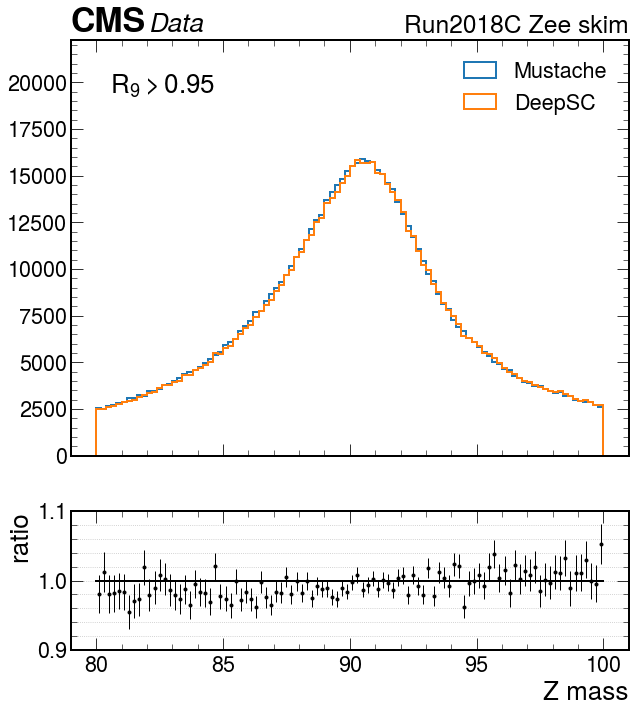

In [226]:
Hm = Zm[Zm.r9>0.95].mass
Hd = Zd[Zd.r9>0.95].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0.95_1", 
                output_folder=output_folder,
                bins=100, xrange=(80,100), label="Z mass",
               wA= np.ones(len(Hd))*norm,
               text="$R_9 > 0.95$", ratio_lim=(0.9,1.1))


### Cut in nvtx

In [233]:
np.quantile(Zm.nvtx, 0.7)

30.0

In [239]:
v = 25
q = np.sum(Zm.nvtx>v)/ len(Zm)
print(q)

0.5187907299887301


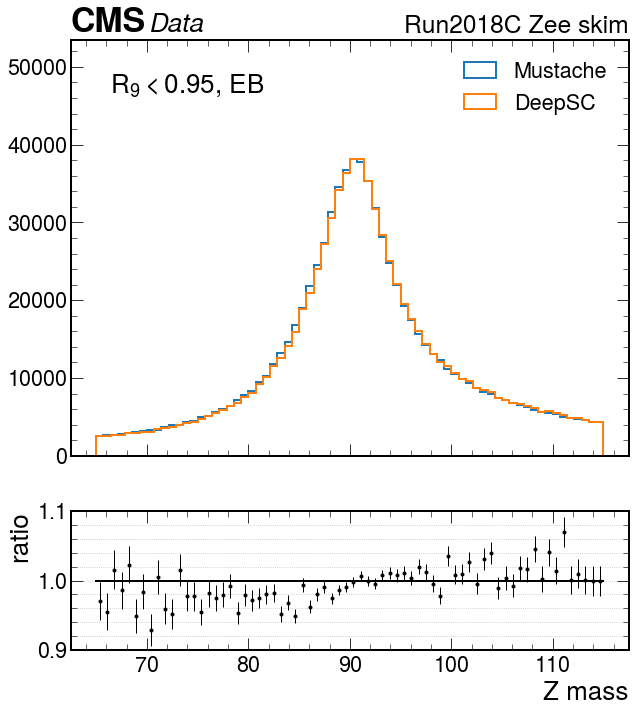

In [278]:
Hm = Zm[(Zm.r9<0.95)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)].mass
Hd = Zd[(Zd.r9<0.95)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_EB", 
                output_folder=output_folder,
                bins=70, xrange=(65,115), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, EB",
               ratio_lim=(0.9,1.1))


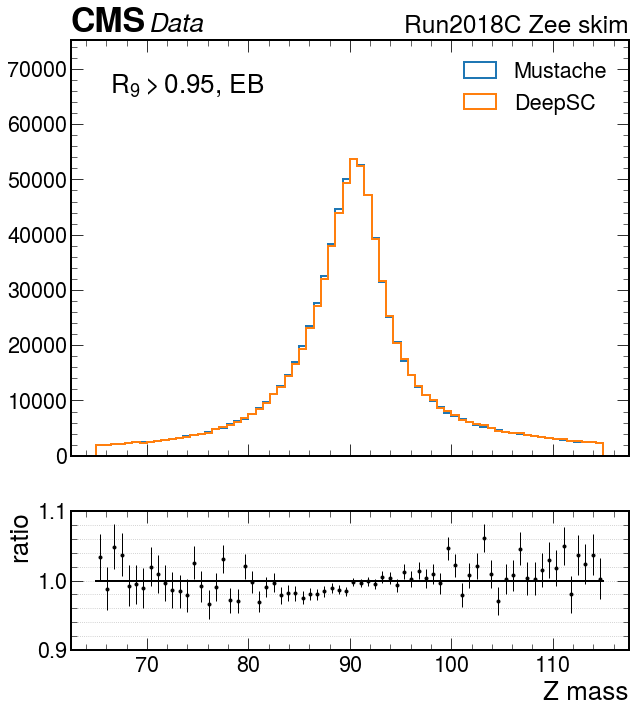

In [279]:
Hm = Zm[(Zm.r9>0.95)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)].mass
Hd = Zd[(Zd.r9>0.95)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_gr0.95_EB", 
                output_folder=output_folder,
                bins=70, xrange=(65,115), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 > 0.95$, EB",
               ratio_lim=(0.9,1.1))


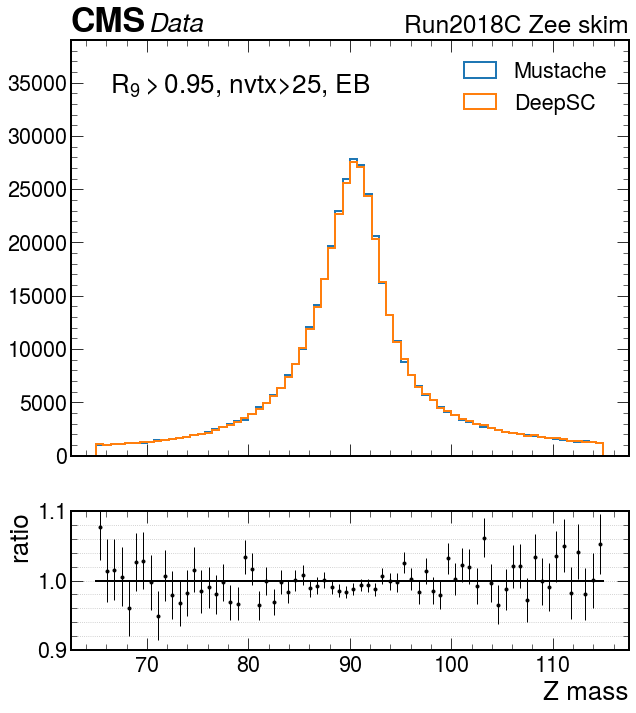

In [281]:
Hm = Zm[(Zm.r9>0.95)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)*(Zm.nvtx>25)].mass
Hd = Zd[(Zd.r9>0.95)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)*(Zd.nvtx>25)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_gr0.95_EB", 
                output_folder=output_folder,
                bins=70, xrange=(65,115), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 > 0.95$, nvtx>25, EB",
               ratio_lim=(0.9,1.1))


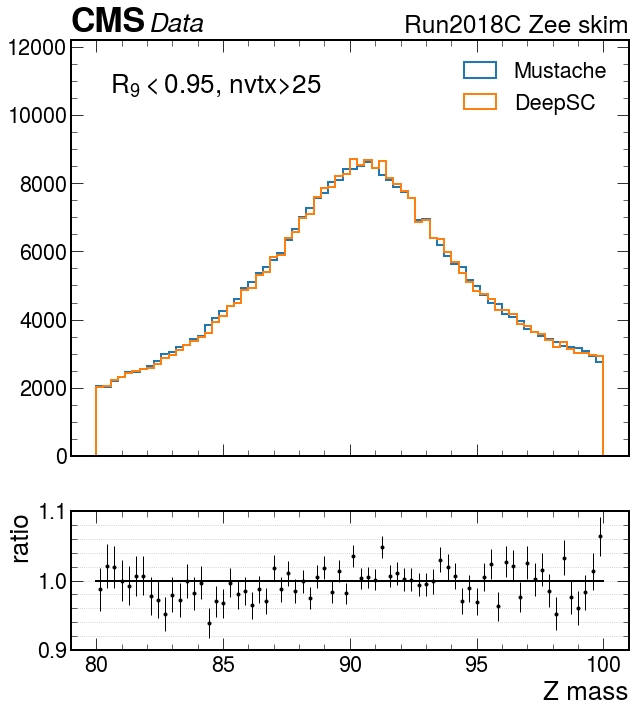

In [259]:
Hm = Zm[(Zm.r9<0.95)&(Zm.nvtx>25)&(Zm.ele_et<100)].mass
Hd = Zd[(Zd.r9<0.95)&(Zd.nvtx>25)&(Zd.ele_et<100)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx25", 
                output_folder=output_foalder,
                bins=70, xrange=(80,100), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, nvtx>25",
               ratio_lim=(0.9,1.1))


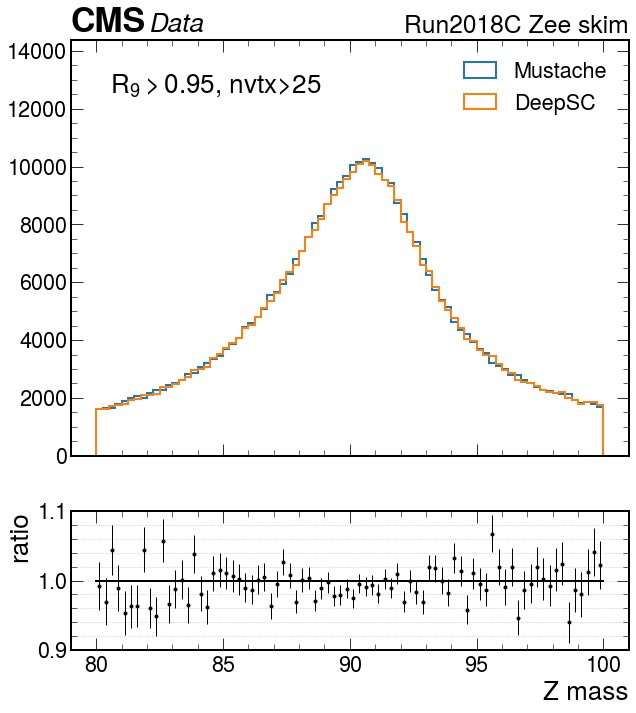

In [258]:
Hm = Zm[(Zm.r9>0.95)&(Zm.nvtx>25)&(Zm.ele_et<100)].mass
Hd = Zd[(Zd.r9>0.95)&(Zd.nvtx>25)&(Zd.ele_et<100)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0.95_1_nvtx25", 
                output_folder=output_folder,
                bins=80, xrange=(80,100), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 > 0.95$, nvtx>25",
               ratio_lim=(0.9,1.1))


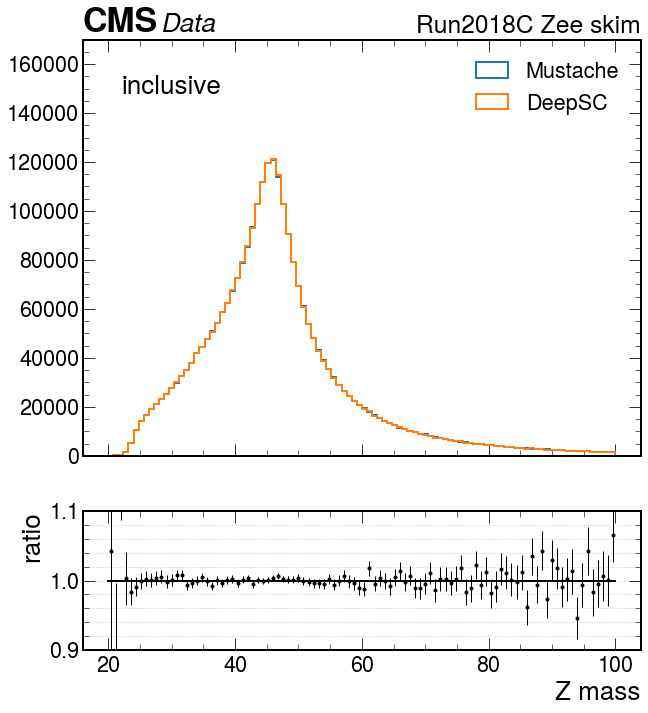

In [252]:
Hm = Zm.ele_et
Hd = Zd.ele_et

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"ele_pt", 
                output_folder=output_folder,
                bins=100, xrange=(20,100), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="inclusive",
               ratio_lim=(0.9,1.1))


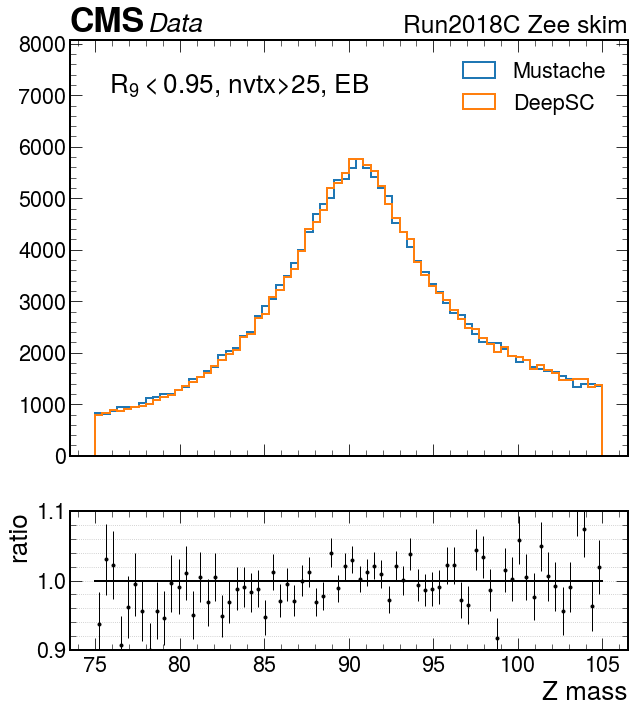

In [269]:
Hm = Zm[(Zm.r9<0.85)&(Zm.nvtx>25)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)].mass
Hd = Zd[(Zd.r9<0.85)&(Zd.nvtx>25)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx25_EB", 
                output_folder=output_folder,
                bins=70, xrange=(75,105), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, nvtx>25, EB",
               ratio_lim=(0.9,1.1))


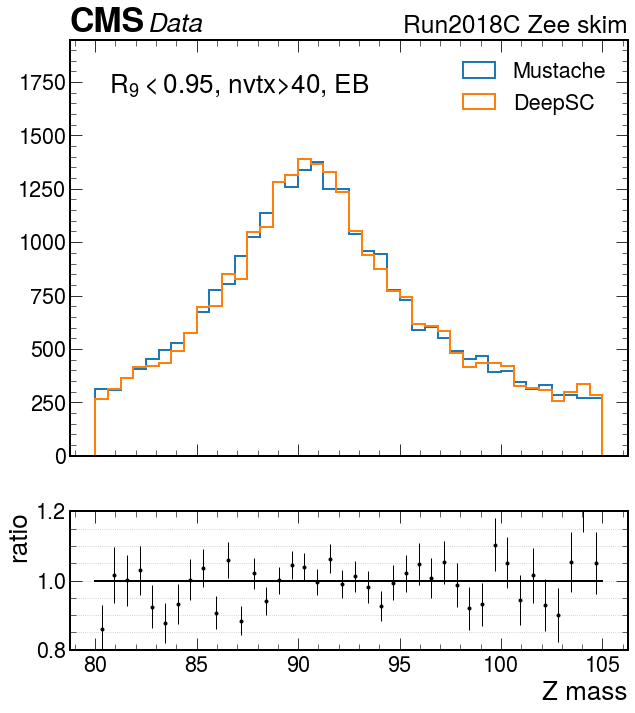

In [277]:
Hm = Zm[(Zm.r9<0.95)&(Zm.nvtx>40)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)].mass
Hd = Zd[(Zd.r9<0.95)&(Zd.nvtx>40)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx40_EB", 
                output_folder=output_folder,
                bins=40, xrange=(80,105), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, nvtx>40, EB",
               ratio_lim=(0.8,1.2))


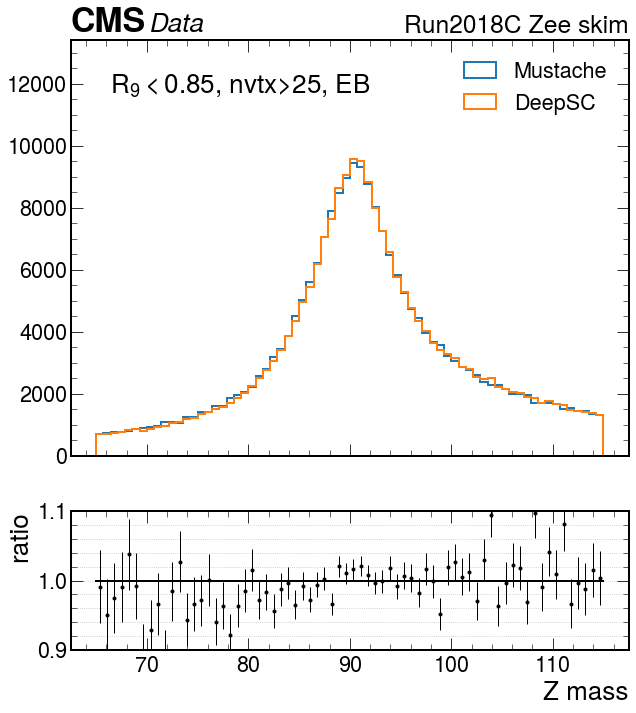

In [273]:
Hm = Zm[(Zm.r9<0.85)&(Zm.nvtx>25)&(Zm.ele_et<100)&(abs(Zm.ele_eta)<1.442)].mass
Hd = Zd[(Zd.r9<0.85)&(Zd.nvtx>25)&(Zd.ele_et<100)&(abs(Zd.ele_eta)<1.442)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx25_EB", 
                output_folder=output_folder,
                bins=70, xrange=(65,115), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.85$, nvtx>25, EB",
               ratio_lim=(0.9,1.1))


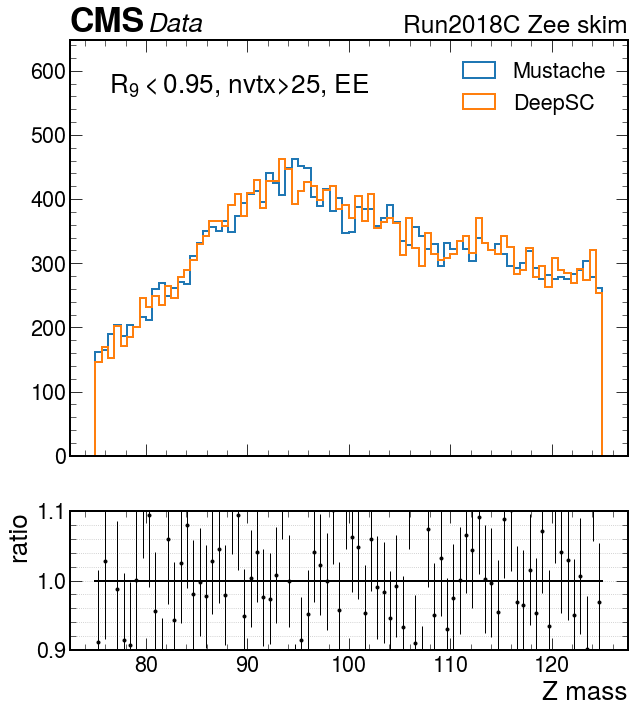

In [268]:
Hm = Zm[(Zm.r9<0.85)&(Zm.nvtx>25)&(Zm.ele_et<100)&(abs(Zm.ele_eta)>1.556)].mass
Hd = Zd[(Zd.r9<0.85)&(Zd.nvtx>25)&(Zd.ele_et<100)&(abs(Zd.ele_eta)>1.556)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx25_EE", 
                output_folder=output_folder,
                bins=80, xrange=(75,125), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, nvtx>25, EE",
               ratio_lim=(0.9,1.1))


# Sigma E

In [ ]:
Hm = Zm[(Zm.r9<0.85)&(Zm.nvtx>25)&(Zm.ele_et<100)&(abs(Zm.ele_eta)>1.556)].mass
Hd = Zd[(Zd.r9<0.85)&(Zd.nvtx>25)&(Zd.ele_et<100)&(abs(Zd.ele_eta)>1.556)].mass

norm = np.sum(Hm)/ np.sum(Hd)

plot_comparison(Hm,Hd,
                var=f"Z_mass_r9_0_0.95_nvtx25_EE", 
                output_folder=output_folder,
                bins=80, xrange=(75,125), label="Z mass",
               wA= np.ones(len(Hd))*norm  ,  text="$R_9 < 0.95$, nvtx>25, EE",
               ratio_lim=(0.9,1.1))


# Fitting

In [95]:
from plotting_code import *

In [96]:
def do_plot(*, name, df1, df2, res_var1, res_var2, 
            bins1, bins2, binlabel1, binlabel2, binvar1, binvar2, binleg,
            xlabel, ylabel, general_label, ylabelratio,
            yvar, ylims1, ylims2, 
            bin_analysis="cruijff",
            yvar_err=None,
            logy = True,
            exclude_x_bin=-1,
            exclude_y_bin=-1,
            nbins_fit=250, prange=1, 
            legendExt = "",
            xlabel_fit = "$E/E_{true}$",
            fill_between=None,  output_folder=None, 
            plot_fits=False,
            load_from_file=False):
            
        
    binCol1 = binlabel1+"_bin"
    binCol2 = binlabel2+"_bin"
    if not load_from_file:
       
        for df in [df1, df2]:
            df.loc[:,binCol1] = pd.cut(df[binvar1].abs(), bins1, labels=list(range(len(bins1)-1)))
            df.loc[:,binCol2] = pd.cut(df[binvar2].abs(), bins2, labels=list(range(len(bins2)-1)))

        if bin_analysis == "cruijff":
            res = df1.groupby([binCol1,binCol2]).apply(bin_analysis_cruijff(f"{res_var1}", nbins=nbins_fit, prange=prange))
            res_must = df2.groupby([binCol1,binCol2]).apply(bin_analysis_cruijff(f"{res_var2}", nbins=nbins_fit, prange=prange))
        elif bin_analysis == "ext_quantile":
            res = df1.groupby([binCol1,binCol2]).apply(bin_analysis_extquantiles(f"{res_var1}"))
            res_must = df2.groupby([binCol1,binCol2]).apply(bin_analysis_extquantiles(f"{res_var2}"))
        elif bin_analysis == "central_quantile":
            res = df1.groupby([binCol1,binCol2]).apply(bin_analysis_central_smallest(f"{res_var1}"))
            res_must = df2.groupby([binCol1,binCol2]).apply(bin_analysis_central_smallest(f"{res_var2}"))
        res.reset_index(level=0, inplace=True)
        res.reset_index(level=0, inplace=True)
        res_must.reset_index(level=0, inplace=True)
        res_must.reset_index(level=0, inplace=True)

        # computing sigma_Avg
        if bin_analysis == "cruijff":
            res.loc[:,"sigma_avg"] = (res.sigmaL + res.sigmaR)/2
            res.loc[:,"sigma_avg_err"] = 0.5 * np.sqrt( res.sigmaL_err**2 + res.sigmaR_err**2)
            res_must.loc[:,"sigma_avg"] = (res_must.sigmaL + res_must.sigmaR)/2
            res_must.loc[:,"sigma_avg_err"] = 0.5 * np.sqrt( res_must.sigmaL_err**2 + res_must.sigmaR_err**2)
    else:
        res = pd.read_csv(f"{output_folder}/resolution_{name}_deepsc.csv", sep=',')
        res_must = pd.read_csv(f"{output_folder}/resolution_{name}_mustache.csv", sep=',')
    
    
    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(bins1)-1):
        errx.append((bins1[i+1]- bins1[i])/2)
        x.append((bins1[i+1]+ bins1[i])/2)

    mustl = []
    deepl = []

    res.loc[res[binCol1] == exclude_x_bin, [yvar]] = 0
    res_must.loc[res_must[binCol1] == exclude_x_bin, [yvar]] = 0
    

    for iet, et in enumerate(bins2[:-1]):
        if iet == exclude_y_bin: continue
        if not yvar_err:
            l = axs[0].errorbar(x, res_must[res_must[binCol2] == iet][yvar], xerr=errx, 
                                label=f"[{bins2[iet]}, {bins2[iet+1]}]", fmt = ".")
        else:
            l = axs[0].errorbar(x, res_must[res_must[binCol2] == iet][yvar], 
                                xerr=errx, yerr=res_must[res_must[binCol2] == iet][yvar_err],
                                label=f"[{bins2[iet]}, {bins2[iet+1]}]", fmt = ".", elinewidth=1)
        mustl.append(l)

    i = 0
    for iet, et in enumerate(bins2[:-1]):
        if iet == exclude_y_bin: continue
        if not yvar_err:
            l = axs[0].errorbar(x, res[res[binCol2]== iet][yvar],  
                            xerr=errx,                    
                            label=f"[{bins2[iet]}, {bins2[iet+1]}]", 
                            c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=0)
        else:
            l = axs[0].errorbar(x, res[res[binCol2]== iet][yvar],  
                            xerr=0,  yerr=res[res[binCol2]== iet][yvar_err],                  
                            label=f"[{bins2[iet]}, {bins2[iet+1]}]", 
                            c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=1) #not drawing the error
        i+=1
        deepl.append(l)

    if fill_between:
        axs[0].fill_between(fill_between, [ylims1[0]]*2,[ylims1[1]]*2, color="lightgray", alpha=0.5)
        axs[1].fill_between(fill_between, [ylims2[0]]*2,[ylims2[1]]*2, color="lightgray", alpha=0.5)


    for iet, et in enumerate(bins2[:-1]):
        if iet == exclude_y_bin: continue
        rd = res[res[binCol2]==iet][yvar]
        rm = res_must[res_must[binCol2]==iet][yvar]
        var = rd/rm
        if not yvar_err:
            axs[1].errorbar(x, var,xerr=errx, fmt=".", linestyle='none', elinewidth=0)
        else:
            # Error of the ratio
            deep_err = res[res[binCol2]==iet][yvar_err]
            must_err = res_must[res_must[binCol2]==iet][yvar_err]
            err_ratio = np.sqrt( ((1/rm)**2) * deep_err**2 + ((rd/(rm**2))**2 )*must_err**2 )
            axs[1].errorbar(x, var,xerr=errx, yerr=err_ratio,
                            fmt=".", linestyle='none', elinewidth=1)

    axs[0].set_ylabel(ylabel)
    axs[1].set_xlabel(xlabel)
    axs[0].set_ylim(*ylims1)
    axs[1].set_ylim(*ylims2)
    

    axs[1].set_ylabel(ylabelratio, fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)

    l1= axs[0].legend(handles=mustl, title=binleg, title_fontsize=18, loc="upper left", fontsize=18)

    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache'+ legendExt )
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC'+ legendExt)
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", 
                  bbox_to_anchor=(0.93, 1), fontsize=18)
    axs[0].add_artist(l1)

    axs[0].text(0.7, 0.62, general_label, transform=axs[0].transAxes, fontsize=20)

    if logy:
        axs[0].set_yscale("log")
    axs[0].grid(which="both",axis="y")
    axs[1].grid(which="both",axis="y")

    hep.cms.label(rlabel="14 TeV", llabel="Simulation Preliminary", loc=0, ax=axs[0]) 
    
    if (output_folder):
        os.makedirs(output_folder, exist_ok=True)
        os.system(f"cp /eos/user/d/dvalsecc/www/index.php {output_folder}")
        fig.savefig(output_folder + f"/resolution_{name}_{yvar}_ratio.png")
        fig.savefig(output_folder + f"/resolution_{name}_{yvar}_ratio.pdf")
        fig.savefig(output_folder + f"/resolution_{name}_{yvar}_ratio.svg")
        
    #######
    #Plot the single fit bins
    if bin_analysis=="cruijff" and plot_fits and output_folder:
        output_fits = output_folder + "/fits_"+ name
        os.makedirs(output_fits, exist_ok=True)
        os.system(f"cp /eos/user/d/dvalsecc/www/index.php {output_fits}")
        
        for iBin1, bin1, in enumerate(bins1[:-1]):
            for iBin2, bin2 in enumerate(bins2[:-1]):
                df_d = df1[(df1[binCol1] == iBin1)&(df1[binCol2]==iBin2)]
                df_m = df2[(df2[binCol1] == iBin1)&(df2[binCol2]==iBin2)]
                fit_deep = res[(res[binCol1]== iBin1)&(res[binCol2]==iBin2)]
                fit_must = res_must[(res_must[binCol1]== iBin1)&(res_must[binCol2]==iBin2)]
                if fit_deep.sigma_avg.values[0] == -1 or fit_must.sigma_avg.values[0]==-1:
                    print(f"Fit failed iBin1:{iBin1}, iBin2:{iBin2}")
                    continue
                    
                fig = plt.figure(figsize=(9,8), dpi=100)
                ax = plt.gca()
                #using same range and nbins for both plots
                H_m = np.histogram(df_m[res_var2],bins=nbins_fit, range=(fit_must.xmin.values[0], fit_must.xmax.values[0]))
                xm = H_m[1][:-1]
                Ym = H_m[0]
                ax.errorbar(xm, Ym, np.sqrt(Ym),0, linestyle='none',fmt=".", label="Mustache"+legendExt,zorder=0)


                H_d = np.histogram(df_d[res_var1],bins=nbins_fit, range=(fit_deep.xmin.values[0], fit_deep.xmax.values[0]))
                xd = H_d[1][:-1]
                Yd = H_d[0]
                ax.errorbar(xd, Yd, np.sqrt(Yd),0, linestyle='none', fmt=".",label="DeepSC"+legendExt, zorder=1)


                y_cr_D = cruijff(xd, fit_deep.A.values[0], fit_deep.m.values[0], fit_deep.sigmaL.values[0], 
                                 fit_deep.sigmaR.values[0], fit_deep.alphaL.values[0], fit_deep.alphaR.values[0])
                
                y_cr_M = cruijff(xm, fit_must.A.values[0], fit_must.m.values[0], fit_must.sigmaL.values[0],
                                 fit_must.sigmaR.values[0], fit_must.alphaL.values[0], fit_must.alphaR.values[0])
                
                ax.plot(xm, y_cr_M, label="Cruijiff Mustache", linewidth=3, zorder=10, color="green")
                ax.plot(xd, y_cr_D, label="Cruijiff DeepSC", linewidth =3, zorder=11, color="red")

                ax.legend(loc="upper right", bbox_to_anchor=(1, 1), fontsize=17)
                ax.text(0.05, 0.9, f"Mustache:\nm={fit_must.m.values[0]:.3f}, $\sigma_L$={fit_must.sigmaL.values[0]:.3f}, $\sigma_R$={fit_must.sigmaR.values[0]:.3f}",
                        transform=ax.transAxes, fontsize=15, color="green")
                ax.text(0.05, 0.8, f"DeepSC:\nm={fit_deep.m.values[0]:.3f}, $\sigma_L$={fit_deep.sigmaL.values[0]:.3f}, $\sigma_R$={fit_deep.sigmaR.values[0]:.3f}",
                        transform=ax.transAxes, fontsize=15, color="red")

                ax.text(0.05, 0.65, f"{xlabel} [{bins1[iBin1]},{bins1[iBin1+1]}] \n{binleg}: [{bins2[iBin2]},{bins2[iBin2+1]}]",
                        transform=ax.transAxes, fontsize=17)
                
                ax.text(0.65, 0.65, general_label, transform=ax.transAxes, fontsize=20)

                ax.set_ylim(0,max(Yd)*1.5)
                ax.set_xlabel(xlabel_fit)
                hep.cms.label(rlabel="14 TeV",  llabel="Simulation Preliminary", loc=0, ax=ax)

                if (output_folder):
                    fig.savefig(output_fits + f"/cruijff_fit_{binlabel1}{bins1[iBin1]}_{bins1[iBin1+1]}_{binlabel2}{bins2[iBin2]}_{bins2[iBin2+1]}.png")
                    fig.savefig(output_fits + f"/cruijff_fit_{binlabel1}{bins1[iBin1]}_{bins1[iBin1+1]}_{binlabel2}{bins2[iBin2]}_{bins2[iBin2+1]}.pdf")
                    fig.savefig(output_fits + f"/cruijff_fit_{binlabel1}{bins1[iBin1]}_{bins1[iBin1+1]}_{binlabel2}{bins2[iBin2]}_{bins2[iBin2+1]}.svg")
                plt.close()
                
    if output_folder:
        res.to_csv(f"{output_folder}/resolution_{name}_deepsc.csv", sep=',', index=False)
        res_must.to_csv(f"{output_folder}/resolution_{name}_mustache.csv", sep=',', index=False)
    
    return res, res_must

Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed
Fit failed iBin1:0, iBin2:0
Fit failed iBin1:0, iBin2:1
Fit failed iBin1:0, iBin2:2
Fit failed iBin1:0, iBin2:3
Fit failed iBin1:1, iBin2:0
Fit failed iBin1:1, iBin2:1
Fit failed iBin1:1, iBin2:2
Fit failed iBin1:1, iBin2:3
Fit failed iBin1:2, iBin2:0
Fit failed iBin1:2, iBin2:1
Fit failed iBin1:2, iBin2:2
Fit failed iBin1:2, iBin2:3


/tmp/ipykernel_12955/3011205683.py:201: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0,max(Yd)*1.5)
/tmp/ipykernel_12955/3011205683.py:201: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0,max(Yd)*1.5)
/tmp/ipykernel_12955/3011205683.py:201: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0,max(Yd)*1.5)
/tmp/ipykernel_12955/3011205683.py:201: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0,max(Yd)*1.5)


Fit failed iBin1:4, iBin2:0
Fit failed iBin1:4, iBin2:1
Fit failed iBin1:4, iBin2:2
Fit failed iBin1:4, iBin2:3
Fit failed iBin1:5, iBin2:0
Fit failed iBin1:5, iBin2:1
Fit failed iBin1:5, iBin2:2
Fit failed iBin1:5, iBin2:3


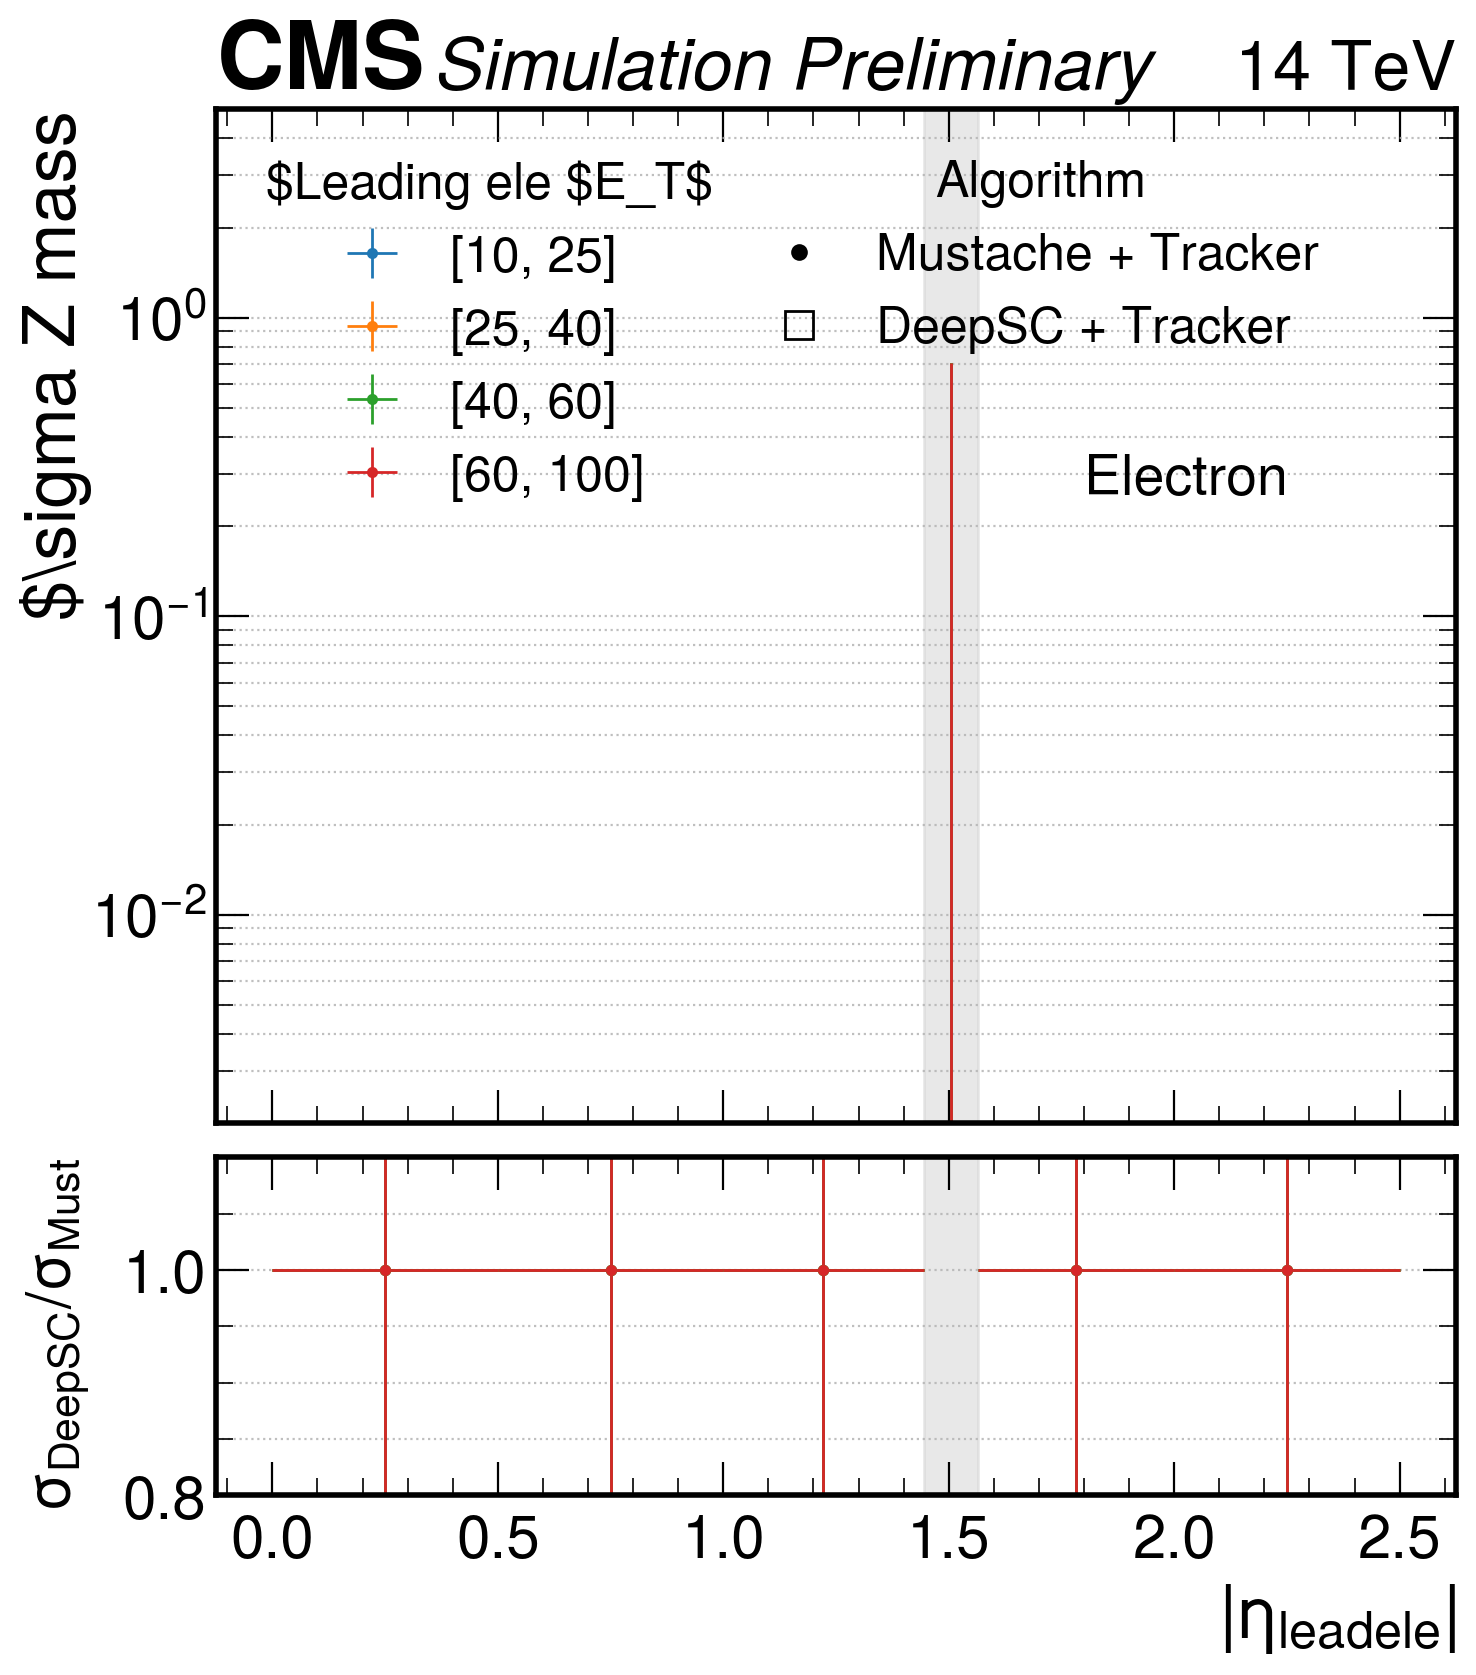

In [99]:
res_d, res_m = do_plot(name="test",
        df1=Zm, 
        df2=Zd,
        res_var1="mass", 
        res_var2="mass",
        bins1=[0, 0.5,1.0,1.4442, 1.566, 2.,2.5],
        bins2=[10,25, 40, 60,100], 
        binlabel1="ele_eta",
        binlabel2="ele_et",
        binleg="$Leading ele $E_T$", 
        binvar1="ele_eta", 
        binvar2="ele_et", 
        nbins_fit=350, 
        prange=0.965, 
        exclude_x_bin=3, 
        general_label="Electron", 
        legendExt = " + Tracker",
        xlabel_fit = "$E_{calib}/E_{Gen}$",
        xlabel="$|\eta_{lead ele}|$", 
        ylabel="$\sigma Z mass",
        ylabelratio="$\sigma_{DeepSC}/\sigma_{Must}$", 
        yvar="sigma_avg",
        bin_analysis="cruijff",
        yvar_err="sigma_avg_err",
        ylims1=(2e-3,5),
        ylims2=(0.8, 1.1),
        fill_between=[1.4442, 1.566],
        output_folder=output_folder, 
        plot_fits=True, 
        load_from_file=False)
